In [24]:
import numpy as np 
import math
import peakutils
import numpy.fft as fft
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from matplotlib import cm  
import scipy.integrate 
import scipy.signal as signal 
import pandas as pd

import pickle 
import random as rand  
from numpy import random

from sklearn import decomposition 
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans  
import os.path 

#from sympy import latex 


# The class belows has the cost function and ODEs, as well as the plotting function 

In [58]:
'''
The deterministic model of biological oscillator
''' 
class Oscillator: 
	
	def __init__(self, parameter_ranges, params, mode = 0): 
		#parameter_ranges and params will only include those parameters that
        #will be under optimization
		self.nParams = len(params)   
		self.paramsToOpt = params #model parameters to be optimized
		self.parameter_ranges = parameter_ranges #allowed parameter ranges  
        #self.y0 = initial_conditions 	

		self.tMax = 4.5
        #Define System geometry: A in um2, V in um3
		self.Atotal=4.34
		self.Acluster=0.023
		self.V=8.25
        #3D to 2D lengthscale in um
		self.h = 0.01 
        #Dimensionality factor
		self.gamma = self.V/(self.Atotal*self.h)
        
        #define system geometry for the dense clusters.
		self.AtotalDense=0.57
		self.AclusterDense=0.026
		self.VDense=1.083
        #Dimensionality factor, should be same in dense and dilute
		self.gammaDense = self.VDense/(self.AtotalDense*self.h)
		self.densIncrease = 7 #factor increase in density on the membrane
        #0.1   0.2154   0.46416 1   2.154   4.6416 10   21.54   46.416 100
		#self.targetRateRatio = targetRateR #factor speed up of dynamin relative to activator binding
		#self.targetDensRatio = targetDensR #factor increase of dilute relative to cluster density
		expDt=0.02
		#dt=0.001
		nTimePoints=int(self.tMax/expDt)
		self.timePoints=[i*expDt for i in range(nTimePoints)] 
		#self.T = 200 ## time you are integrating over
		#self.N = int(self.T/self.dt) 
		#self.ts = np.linspace(0, self.T, self.N) 
		#self.expdata=pd.read_table("exp_dyn1ab.dat", header=None,sep="\s+",names=['time','expInt','expSEM'])
		#startToZero=15 #time series starts at -15!
		self.expdata=pd.read_table("expdataBB_from4.dat", header=None,sep="\s+",names=['time','expInt','expSEM'])
		startToZero=4 #time series starts at -15!
		self.expTime=self.expdata.time+startToZero 
		targetIncrease=45 #how much should intensity increase
		N=len(self.expdata)
        #make relative intensity higher!
		self.delIntensity=(self.expdata.expInt[N-1]-targetIncrease*self.expdata.expInt[0])/(1.0-targetIncrease)
		print('delIntensity: '+str(self.delIntensity))
		targetIncreasePost=14 #how much should intensity increase
        #make relative intensity higher!
		self.delIntensityPost=(self.expdata.expInt[N-1]-targetIncreasePost*self.expdata.expInt[0])/(1.0-targetIncreasePost)
		print('delIntensityPost: '+str(self.delIntensityPost))
        #        self.amp = 300 #[nM] 		
		#self.per = self.T/8 	

		self.mode = mode    
        
		self.modes = [self.eval_both]    
		self.threshold = -500000  

		#if self.mode == 1:
		#self.threshold = thresholdTwo

		
	def costChi_pre(self, Y): 
		#Define relative intensity that is compared to the experimental data
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		sem=self.expdata.expSEM/(self.expdata.expInt[0]-self.delIntensity)
		copies=Y*self.V*602
        #print(solution.y[0][10])
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
        #2D vs 3D recruitment growth
        
		#print("Size of solution")
		#print(len(acd))
		#print("Size of Exp data")
		#print(len(relInt))
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #print(twoDvs3D)
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		nPt=len(relInt)
		nPsol=len(acd)
		if(nPsol<nPt):
			cost=self.threshold*2
			print("too few points in solution") 
			print(nPsol)
			print("need: "+str(nPt)+ " points.")
		else:
			#diff = relInt - intensRatio[0:nPt]
            #take the negative, so closer to zero is better
			#cost = -np.dot(diff, diff)
			sum=0
			for i in range(nPt):
				df=relInt[i]-intensRatio[i]
				sum=sum+df*df/(sem[i]*sem[i]) 
			cost=-sum
		return [cost]
    
	def costChi_post(self, Y): 
		#Define relative intensity that is compared to the experimental data
		relInt=(self.expdata.expInt-self.delIntensityPost)/(self.expdata.expInt[0]-self.delIntensityPost)
		sem=self.expdata.expSEM/(self.expdata.expInt[0]-self.delIntensityPost)
		copies=Y*self.VDense*602
        #print(solution.y[0][10])
		c=copies[3]/self.AtotalDense #Rdilute
		ac=copies[1]/self.AtotalDense #Ddilute
		acd=copies[4]/self.AclusterDense #Dclus2D
		ad=copies[5]/self.AclusterDense #Dclus3D
        #2D vs 3D recruitment growth
        
		#print("Size of solution")
		#print(len(acd))
		#print("Size of Exp data")
		#print(len(relInt))
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #print(twoDvs3D)
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		nPt=len(relInt)
		nPsol=len(acd)
		if(nPsol<nPt):
			cost=self.threshold*2
			print("too few points in solution") 
			print(nPsol)            
		else:
			#diff = relInt - intensRatio[0:nPt]
            #take the negative, so closer to zero is better
			#cost = -np.dot(diff, diff)
			sum=0
			for i in range(nPt):
				df=relInt[i]-intensRatio[i]
				sum=sum+df*df/(sem[i]*sem[i]) 
			cost=-sum
		return [cost]
    
    
	
		
	def isViableFitness(self, fit):
        #the cost function is to be maximized, greater than some threshold
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.eval_both(point)  
		#if self.mode == 0:
		#print(point)
		#print(fitness[0])
		return self.isViableFitness(fitness[0]) #don't need zero index if 1D
			
		#fit = fitness[0] 
		#amp = 0
		#if fit > 0:
		#	amp = fitness[1] 
		#return self.isViableFitness(fit) and amp >= self.minAmp and amp <= self.maxAmp   
		
	#evaluates a candidate  
	def eval_both(self, candidate): 
		[solutionPre, solutionPost]=self.simulate(candidate)
		Ypre = np.array(solutionPre) 
		copies=Ypre*self.V*602
        #print(solution.y[0][10])
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
        #2D vs 3D recruitment growth

		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point

		chiPre=self.costChi_pre(Ypre)
        #now evaluate fit post
		Ypost = np.array(solutionPost) 
		copies=Ypost*self.VDense*602
        #print(solution.y[0][10])
		c=copies[3]/self.AtotalDense #Rdilute
		ac=copies[1]/self.AtotalDense #Ddilute
		acd=copies[4]/self.AclusterDense #Dclus2D
		ad=copies[5]/self.AclusterDense #Dclus3D
        #2D vs 3D recruitment growth
        #print(len(acd))
        #print(len(ad))
		twoDvs3DPost=np.divide(acd[1:], ad[1:]) #ignore the 1st point
		#if self.mode == 0:
		#	return self.costOne(Y)  
		#else:
		#	return self.costTwo(Y, getAmplitude)
		chiPost=self.costChi_post(Ypost)
		chiTotal=chiPre[0]+chiPost[0]
		chiStr=[chiTotal,]        
		return [chiStr, twoDvs3D[0], twoDvs3DPost[0]]


        
#simulate a candidate pre-stimulation
	def simulate_pre(self, candidate):
        #Most of the model parameters needed for the simulation are defined
        #in the Oscillator class
        #"kfDRC","Rdilute0","Dsol0","Dmem0"
		kfDRC=candidate[0] #binding to cluster activator, irreversible
		kfDRD=candidate[6] #binding to dilute recruiter is reversible
		kfDydy=kfDRC*candidate[4] #4 is targetRateRatio
		Dsol0=candidate[2] #units of uM: this is equilibrium pre-activation
		DmemDens=candidate[3] #units of /um2
		RclusDens=DmemDens/candidate[5]  #5 is targetDensRatio
		RdiluteDens = candidate[1]
        #convert all densities to uM units
		Dmem0=DmemDens*self.Atotal/self.V/602.0 
		DynTotal=Dsol0+Dmem0 #units of uM        
		Rclus0=RclusDens*self.Acluster/self.V/602.0
		Rdilute0=RdiluteDens*self.Atotal/self.V/602.0
        #rates for model
        #off rates, s-1
		kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD;
		kbDRC=kbDRD
		#kbDRC=0
		rateParams=np.array([kfDRC, kfDRD, kbDRC, kbDRD, self.gamma, kfDydy])
        #init values for model
		#print(rateParams)        
		initValues=np.array([Dsol0,Dmem0,Rclus0,Rdilute0,0,0])
        #Solve the ODE from 0 to tMax
		#print(initValues) 
		solution = scipy.integrate.solve_ivp(fun=self.dynaminOde,method='Radau', t_span=(0, self.tMax), y0=initValues, t_eval=self.timePoints, args=(rateParams,), rtol=1e-7, atol=1e-9)
        #solution = solve_ivp(self.dynaminOde, self.ts, initValues, args=(candidate, fixed_params))
		return solution.y
    #odeint(self.oscillatorModelOde, candidate[15:], self.ts, args=(candidate,))   		

    
#simulate a candidate post-stimulation
	def simulate_post(self, candidate):
        #Most of the model parameters needed for the simulation are defined
        #in the Oscillator class
        #"kfDRC","Rdilute0","Dsol0","Dmem0"
		kfDRC=candidate[7] #binding to activator has a new rate!
		kfDRD=candidate[6] #binding to dilute recruiter is reversible
		kfDydy=candidate[0]*candidate[4] #4 is targetRateRatio
 #units of uM: this is the equilibrium pre-activation
		DynTotal=candidate[2]+candidate[3]*self.AtotalDense/self.VDense/602.0 #units of uM
        #increase the total amount of dynamin on the membrane
		DmemDens=candidate[3]*self.densIncrease #units of /um2
        #Here we could change the concentration of activator in the cluster.
		RclusDens=candidate[3]/candidate[5]  #5 is targetDensRatio
		RdiluteDens = candidate[1]
        #convert all densities to uM units
		Dmem0=DmemDens*self.AtotalDense/self.VDense/602.0 
		Dsol0=DynTotal-Dmem0 #amount of dynamin conc in solution now
        #Now for post-stimulation, we need to re-evaluate dynamin copies to place 5x more on the membrane
		Rclus0=RclusDens*self.AclusterDense/self.VDense/602.0
		Rdilute0=RdiluteDens*self.AtotalDense/self.VDense/602.0
        #rates for model
        #off rates, s-1
		kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD;# this rate will be slower, since Dmem is now higher.
		kbDRC=kbDRD
		#kbDRC=0
		rateParams=np.array([kfDRC, kfDRD, kbDRC, kbDRD, self.gamma, kfDydy])
        #init values for model
		#print(rateParams)        
		initValues=np.array([Dsol0,Dmem0,Rclus0,Rdilute0,0,0])
        #Solve the ODE from 0 to tMax
		#print(initValues) 
		solution = scipy.integrate.solve_ivp(fun=self.dynaminOde,method='Radau', t_span=(0, self.tMax), y0=initValues, t_eval=self.timePoints, args=(rateParams,), rtol=1e-7, atol=1e-9)
        #solution = solve_ivp(self.dynaminOde, self.ts, initValues, args=(candidate, fixed_params))
		return solution.y
    #odeint(self.oscillatorModelOde, candidate[15:], self.ts, args=(candidate,))   		

	#simulates a candidate
	def simulate(self, candidate):
        
        #simulate the prestimulation model
		solutionPre=self.simulate_pre(candidate)
        #simulate the post-stimulation model
		solutionPost=self.simulate_post(candidate)
		return [solutionPre, solutionPost]
    
	def plotModel(self, subject, mode="ode", show=True):     		
		if mode == "ode":
			t = self.timePoints
			[solutionPre, solutionPost] = self.simulate(subject) 			
		#else:
			#ssa simulation
			#ts,Y = self.represilatorStochastic(subject)
			
		fig = plt.figure(figsize=(8,4),dpi=200)
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		copies=solutionPre*self.V*602
        #print(solution.y[0][10])
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
        #2D vs 3D recruitment growth
        #print(len(acd))
        #print(len(ad))
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #print(twoDvs3D)
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		plt.plot(self.timePoints, intensRatio, color="k", label='Model')
		plt.plot(self.expTime, relInt, color="r",label="experiment")
		#plt.plot(t,solutions[:,0], color="b", label = 'Dsol')
		#plt.plot(t,solutions[:,1], color="g", label = 'Ddilute')
		#plt.plot(t,solutions[:,2], color="gold", label = 'Rcluster')
		#plt.plot(t,solutions[:,3], color="r", label = 'Rdilute')
		#plt.plot(t,solutions[:,4], color="cyan", label = 'Dclus2D')
		#plt.plot(t,solutions[:,5], color="black", label = 'Dclus3D')
		#plt.plot(t,solutions[:,6], color="indigo", label = 'LpA')
		#plt.plot(t,solutions[:,7], color="yellow", label = 'LpAK')
		#plt.plot(t,solutions[:,8], color="magenta", label = 'LpAP')
		#plt.plot(t,solutions[:,9], color="deeppink", label = 'LpAPLp')
		#plt.plot(t,solutions[:,10], color="peru", label = 'LpAKL')

		#plt.plot(t,solutions[:,11], color="purple", label = 'PLp')


		plt.xlabel('Time (s)')
		#plt.ylabel('Concentration (uM)')
		plt.ylabel('Relative intensity')
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
			 				
	def plotModelBoth(self, subject, mode="ode", show=True):     		
		if mode == "ode":
			t = self.timePoints
			[solutionPre, solutionPost] = self.simulate(subject) 			
		#else:
			#ssa simulation
			#ts,Y = self.represilatorStochastic(subject)
			
		fig = plt.figure(figsize=(8,4),dpi=200)
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		copies=solutionPre*self.V*602
        #print(solution.y[0][10])
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		plt.plot(self.timePoints, intensRatio, color="k", label='Model')
		plt.plot(self.expTime, relInt, color="r",label="experiment Pre")
        
		relInt=(self.expdata.expInt-self.delIntensityPost)/(self.expdata.expInt[0]-self.delIntensityPost)
		copies=solutionPost*self.VDense*602
        #print(solution.y[0][10])
		c=copies[3]/self.AtotalDense #Rdilute
		ac=copies[1]/self.AtotalDense #Ddilute
		acd=copies[4]/self.AclusterDense #Dclus2D
		ad=copies[5]/self.AclusterDense #Dclus3D
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		plt.plot(self.timePoints, intensRatio, color="b", label='Post')
		plt.plot(self.expTime, relInt, color="deeppink",label="experiment Post")
		plt.xlabel('Time (s)')

		plt.ylabel('Relative intensity')
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
			 				

 

	def plotSolution(self, solutions, show=True):     

		t = self.timePoints

		fig = plt.figure(figsize=(8,4),dpi=200)
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		copies=solutions*self.V*602
        #print(solution.y[0][10])
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
		clus=copies[2]/self.Acluster #recruiters in cluster
		dsol=solutions[0] #in uM        
        #2D vs 3D recruitment growth
        #print(len(acd))
        #print(len(ad))
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #print(twoDvs3D)
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		plt.plot(self.timePoints, intensRatio, color="k", label='Model')
		plt.plot(self.expTime, relInt, color="r",label="experiment")

		plt.xlabel('Time (s)')
		#plt.ylabel('Concentration (uM)')
		plt.ylabel('Relative intensity')
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
		fig = plt.figure(figsize=(8,4),dpi=200)
		plt.plot(t,c, color="b", label = 'Rdilute')
		plt.plot(t,ac, color="g", label = 'DMemdilute')
		plt.plot(t,acd, color="gold", label = 'Dclus2D')
		plt.plot(t,ad, color="r", label = 'Dclus3D')
		plt.plot(t,clus, color="k", label = 'RecCluster')
		plt.plot(t,dsol, color="magenta", label = 'Dsol uM')

		plt.xlabel('Time (s)')
		#plt.ylabel('Concentration (uM)')
		plt.ylabel('Density')
        
		plt.ylim(-1,6)
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
			 				
	def plotSolutionDense(self, solutions, show=True):     

		t = self.timePoints

		fig = plt.figure(figsize=(8,4),dpi=200)
		relInt=(self.expdata.expInt-self.delIntensityPost)/(self.expdata.expInt[0]-self.delIntensityPost)
		copies=solutions*self.VDense*602
        #print(solution.y[0][10])
		c=copies[3]/self.AtotalDense #Rdilute
		ac=copies[1]/self.AtotalDense #Ddilute
		acd=copies[4]/self.AclusterDense #Dclus2D
		ad=copies[5]/self.AclusterDense #Dclus3D
		clus=copies[2]/self.AclusterDense #recruiters in cluster
		dsol=solutions[0] #in uM        
        #2D vs 3D recruitment growth
        #print(len(acd))
        #print(len(ad))
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #print(twoDvs3D)
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		plt.plot(self.timePoints, intensRatio, color="k", label='Model')
		plt.plot(self.expTime, relInt, color="b",label="post experiment")

		plt.xlabel('Time (s)')
		#plt.ylabel('Concentration (uM)')
		plt.ylabel('Relative intensity')
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
		fig = plt.figure(figsize=(8,4),dpi=200)
		plt.plot(t,c, color="b", label = 'Rdilute')
		plt.plot(t,ac, color="g", label = 'DMemdilute')
		plt.plot(t,acd, color="gold", label = 'Dclus2D')
		plt.plot(t,ad, color="r", label = 'Dclus3D')
		plt.plot(t,clus, color="k", label = 'RecCluster')
		plt.plot(t,dsol, color="magenta", label = 'Dsol uM')

		plt.xlabel('Time (s)')
		#plt.ylabel('Concentration (uM)')
		plt.ylabel('Density')
        
		plt.ylim(-1,10)
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
			 				



	def plotModelSaveFile(self, subject, file3, mode="ode", show=True):     		
		if mode == "ode":
			t = self.timePoints
			[solutionPre, solutionPost] = self.simulate(subject) 			
		fig = plt.figure(figsize=(8,4),dpi=200)
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		copies=solutionPre*self.V*602
        #print(solution.y[0][10])
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
        #2D vs 3D recruitment growth
        #print(len(acd))
        #print(len(ad))
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
        #print(twoDvs3D)
        
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac),ac[0]) 
                 
		plt.plot(self.timePoints, intensRatio, color="k", label='Model')
		plt.plot(self.expTime, relInt, color="r",label="experiment")

		plt.xlabel('Time (s)')
		#plt.ylabel('Concentration (uM)')
		plt.ylabel('Relative intensity')
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
		f1=open(str(file3),"w")
		dfs=pd.DataFrame([self.timePoints, intensRatio, twoDvs3D]).T
		dfs.to_csv(f1, sep='\t',header=["time","intensRatio","twoDvs3d"])#,header=["time(s)", "RelIntensity","twoDvs3D"])



            
	def dynaminOde(self, t,y, rateParams): 
        #irreversible binding in the cluster!
        #PARAMETERS NEEDED FOR MODEL
        
        #kfDRC, kfDRD,  kbDRC, kbDRD, gamma, kfDydy
		kfDRC=rateParams[0] #rate binding to cluster
		kfDRD=rateParams[1] #rate binding to dilute recruiter

		kbDRC=rateParams[2]
		kbDRD=rateParams[3]
		gamma=rateParams[4]
		kfDydy=rateParams[5]

		bind3DtoCluster = -kfDRC*y[0]*y[2]

		bind2DtoCluster = -kfDRC*gamma*y[1]*y[2]
		bind3DtoDilute = -kfDRD*y[0]*y[3]
		bind2DtoDyn = -kfDydy*gamma*y[1]*y[4]
		bind2Dto3DDyn = -kfDydy*gamma*y[1]*y[5]
		bind3DtoDyn = -kfDydy*y[0]*y[4]
		bind3Dto3DDyn = -kfDydy*y[0]*y[5]
        #DYN-DYN interactions, only can occur within the cluster
        #y(2)+y(5)->2y(5)  ; 2D
        #y(2)+y(6)->y(5)+y(6) ; 2D
        #y(1)+y(5)->y(5)+y(6) ; 3D
        #y(1)+y(6)->2y(6) ; 3D
        #dynamin in solution
		dy0 = bind3DtoCluster+bind3DtoDilute+kbDRD*y[1]+bind3DtoDyn+bind3Dto3DDyn;
        #dynamin on membrane
		dy1 = bind2DtoCluster-bind3DtoDilute-kbDRD*y[1]+bind2DtoDyn+bind2Dto3DDyn;
        #recruiter on the cluster membrane
		dy2 = bind3DtoCluster + bind2DtoCluster ;  
        #recruiter on the membrane dilute
		dy3 = bind3DtoDilute+kbDRD*y[1]; 
        #Dynamin in cluster from 2D
		dy4 = -bind2DtoCluster-bind2DtoDyn-bind2Dto3DDyn;
        #Dynamin in cluster from 3D
		dy5 = -bind3DtoCluster -bind3DtoDyn-bind3Dto3DDyn;
		dydt=np.array([dy0, dy1, dy2, dy3, dy4, dy5])
		return(dydt)


# Solver has runs the genetic algorithm (you'll see in init, uses package called DEAP for genetic operations)

In [66]:
'''
The main class
'''
class Solver:
	def __init__(self, model, populationSize=3000, NGEN = 3, nsamples = 1e3):                                                      
		self.model = model            
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.75     	
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate) 
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)  
		self.toolbox.register("mate", tools.cxTwoPoint)
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5)      
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10))     		
	
	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []   
		fitnessVals = []
		twoDVals = []
		for evalMode in self.model.modes: 
			nominalValsMode = []
			fitnessValsMode = []
			twoDValsMode = []
			self.toolbox.register("evaluate", evalMode)   
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print("Current generation")
				print(gen)
				#generate offspprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring):
					[cost, twoD, twoDpost]=self.model.eval_both(ind)     
					#print("cost: ")
					#print(cost)
					#print("fit: ")
					#print(fit)
					#print("2Dvs3D: ")
					#print(twoD)
					if cost[0]>=self.model.threshold and ind not in nominalValsMode:  
						nominalValsMode.append(ind)
						#print("found viable solution, fitness: ")
						print(fit[0])
						#print(cost[0])
						fitnessValsMode.append(fit[0]) 
						twoDValsMode.append(twoD)  
					ind.fitness.values = fit[0]     
				#roulete wheel selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu)) 
				
				rando = np.random.randint(0, len(self.popu))
				rdm_ind = self.popu[rando]
				print(rdm_ind)

				self.model.plotModelBoth(rdm_ind)
			print("Number of viable points: " + str(len(nominalValsMode))) 
			nominalVals.extend(nominalValsMode)     
			fitnessVals.extend(fitnessValsMode)
			twoDVals.extend(twoDValsMode)
		return [nominalVals, fitnessVals, twoDVals]        
		
	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams):
			low=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["min"]
			hi=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["max"]
			value=random.uniform(math.log10(low),math.log10(hi))
			candidate.append(pow(10, value))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"] or candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd >= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]: 
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]  
				if candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]:  
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		#fitVals = []        
		i = 0
		print(" getting Viable points")        
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable
            

			fitness = self.model.eval_both(point) 
			if(fitness[0] >= self.model.threshold):
			#if self.model.isViable(point):
				augPoint=[]
				augPoint.append(fitness)
				for j in range(self.model.nParams):
					augPoint.append(point[j])
				viable.append(augPoint)   		
				#fitVals.append(fitness[0])
		print("shape of viable")
		print(np.shape(viable))
		return viable          
	
       
    #take in a list of candidates and fitnesses, and write a readable file 
	def write_sortedParms(self, viablePoints, viableFitness, twoDVals):
    
		file2="optFitPts_prePostAB_d0.5.txt"
        
		f=open(str(file2),"a")

		#df=pd.DataFrame([viablePoints, viableFitness]).T
		fitValues=[]
		negFitValues=[]   
		print("shape of viableFitness: ")
		print(np.shape(viableFitness))
		for i in range(len(viableFitness)):
			fitValues.append(viableFitness[i][0])
			negFitValues.append(-viableFitness[i][0])
            
		sortFit=sorted(fitValues, reverse=True)
		print(sortFit[len(viableFitness)-1])
		sortPoint1=[]
		sortPoint2=[]
		sortPoint3=[]
		sortPoint4=[]
		idSort=np.argsort(negFitValues) 
		#print(idSort)
		for i in range(len(idSort)):
			index=idSort[i]
			#print(index)
			#print(int(index))
            #index=idSort[i]
			#print(viablePoints[int(index)])
			optParms=viablePoints[int(index)]
			curr2D=twoDVals[int(index)]
			#sortPoint.append(optParms)    
			kfDRC=optParms[0]
			kfDRD=optParms[6] #binding to dilute and cluster recruiter are coupled
			kfDydy=kfDRC*optParms[4] #candidate[1]
			Dsol0=optParms[2] #units of uM
			DmemDens=optParms[3] #units of /um2
			RclusDens=DmemDens/optParms[5]  
			RdiluteDens = optParms[1]
			kfDense = optParms[7]
            #convert all densities to uM units
			Dmem0=DmemDens*self.model.Atotal/self.model.V/602.0 
			Rclus0=RclusDens*self.model.Acluster/self.model.V/602.0
			Rdilute0=RdiluteDens*self.model.Atotal/self.model.V/602.0
            #rates for model
            #off rates, s-1
			kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD;
			kbDRC=kbDRD
			allParms1=np.array([kfDRC, RdiluteDens, Dsol0, DmemDens]) 
			allParms2=np.array([kfDRD, kfDydy, RclusDens, kfDense])  
			allParms3=np.array([kbDRC, kbDRD, self.model.gamma])
			allParms4=np.array([optParms[4], optParms[5], curr2D])
			sortPoint1.append(allParms1)
			sortPoint2.append(allParms2)
			sortPoint3.append(allParms3)
			sortPoint4.append(allParms4)
		df=pd.DataFrame([sortFit, sortPoint1, sortPoint2, sortPoint3, sortPoint4]).T
		df.to_csv(f, sep='\t',header=["Chi2","kfDRC, RdiluteDens, Dsol0, DmemDens","kfDRD, kfDydy, RclusDens, kfDense", "kbDRC, kbDRD, gamma","rateRatio, densRatio, 2Dvs3D"])#,header=["time(s)", "RelIntensity","twoDvs3D"])
		#plot out the best solution
		print("Best solution from initial sampling")
		print("Length of sortFit")
		print(len(viableFitness))       
		print(sortFit[0])     
        #print out the best solution to file.
		file3="bestSolution_rateS_"+"_densS_"+"_Cost_"+str(sortFit[0])+".txt"    
		self.model.plotModelSaveFile(viablePoints[idSort[0]], file3)
#plot out the worst solution
		print("WORST solution from initial sampling")
		print(sortFit[len(idSort)-1])        
		self.model.plotModel(viablePoints[idSort[len(idSort)-1]])

	#Main method  
	def run(self, maxDepth=0):    

		#estimate the initial viable set 
		[viablePoints, viableFitness, twoDVals] = self.findNominalValues()
		self.write_sortedParms(viablePoints, viableFitness, twoDVals)
		print("wrote to file")
		print("done with Solver run")

##### Define parameter ranges and initial conditions

In [67]:
## DEFINE YOUR RANGES FOR THE GA ##

parameter_ranges = { 
        #sample the rate, dynSol, activator density
    
        #kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD;#initially, the dynamin is in equilibrium with the membrane
        #kbDRC=kbDRD; #unbinding from the cluster has the same off rate
        
    #units of uM-1s-1
            "kfDRC": {"min": 0.0001, "max": 1}, #[0]
           # 
            "RdiluteDens": {"min": 1, "max": 500}, #[1]            				        
           # "kbDRC": {"min": 1, "max": 1}, 
           # "kbDRD": {"min": 1, "max":1}, 
            "Dsol0": {"min": 0.5, "max": 0.5},         #[2]
            "Dmem0": {"min": 10, "max": 70},#[3]
            "targetRateR": {"min": 0.01, "max": 100},#[4]
            "targetDensR": {"min": 0.01, "max": 100},#[5]
            "kfDRD": {"min": 0.0001, "max": 1},#[6]
                #rate to bind activator in the dense phase
            "kfDense": {"min": 0.0001, "max": 1},#[7]
    
            #"Rclus0": {"min": 1, "max": 100}, 
            #"Rdilute0": {"min": 1, "max": 100}, 
            #"V": {"min": 3.53, "max": 3.53},#um3
            #"Atotal": {"min": 1.85, "max": 1.85}, #um2
            #"Acluster": {"min": 0.022, "max": 0.022}, #um2
            }   	

 

## INPUT THE LABELS OF THOSE PARAMETERS INTO SECOND ARGUMENT BELOW, INITIAL CONDITIONS IN THE THIRD
#parameter_values, params, initial_conditions,
paramsToOpt=np.array(["kfDRC","RdiluteDens","Dsol0","Dmem0","targetRateR","targetDensR","kfDRD","kfDense"])
#initValues=np.array(["Dsol0","Dmem0","Rclus0","Rdilute0",0,0])

# Simulate a model given input parameters

delIntensity: 1522.6705045454546
delIntensityPost: 1504.9943153846154


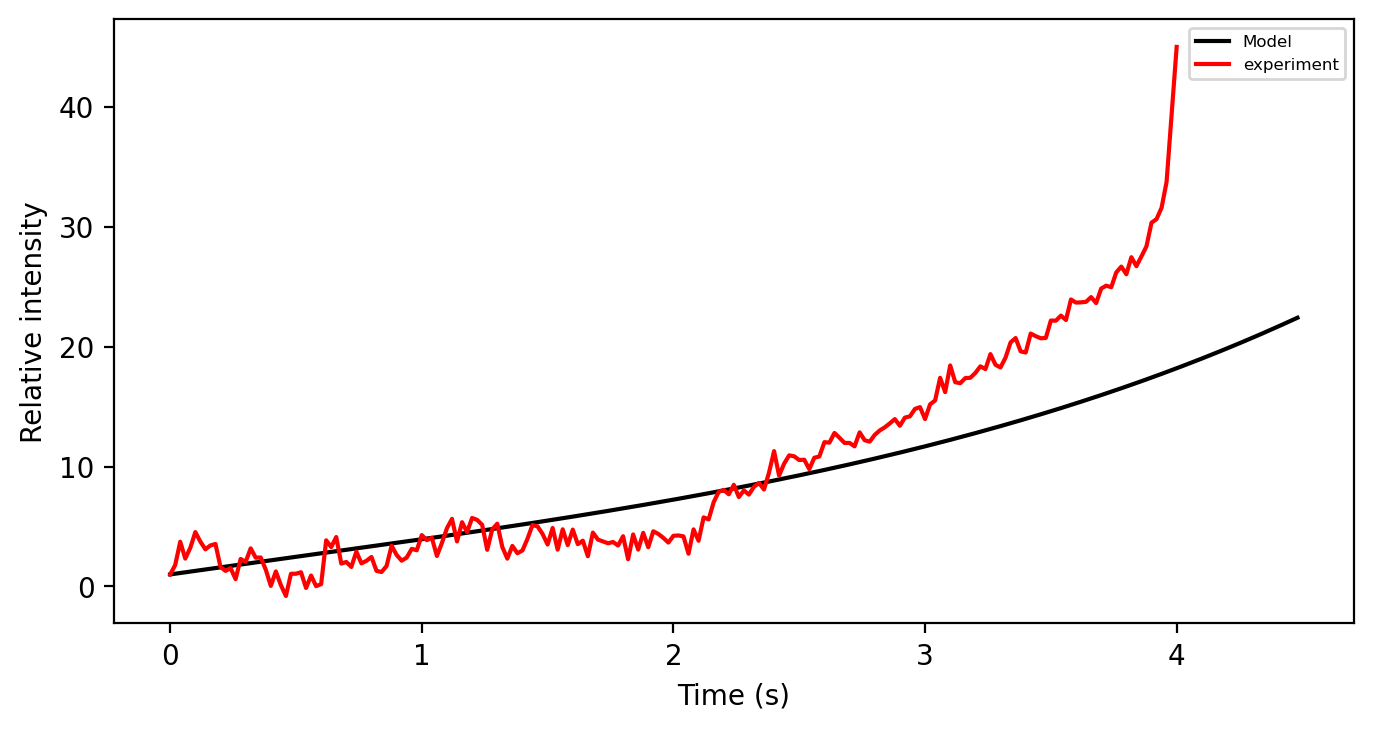

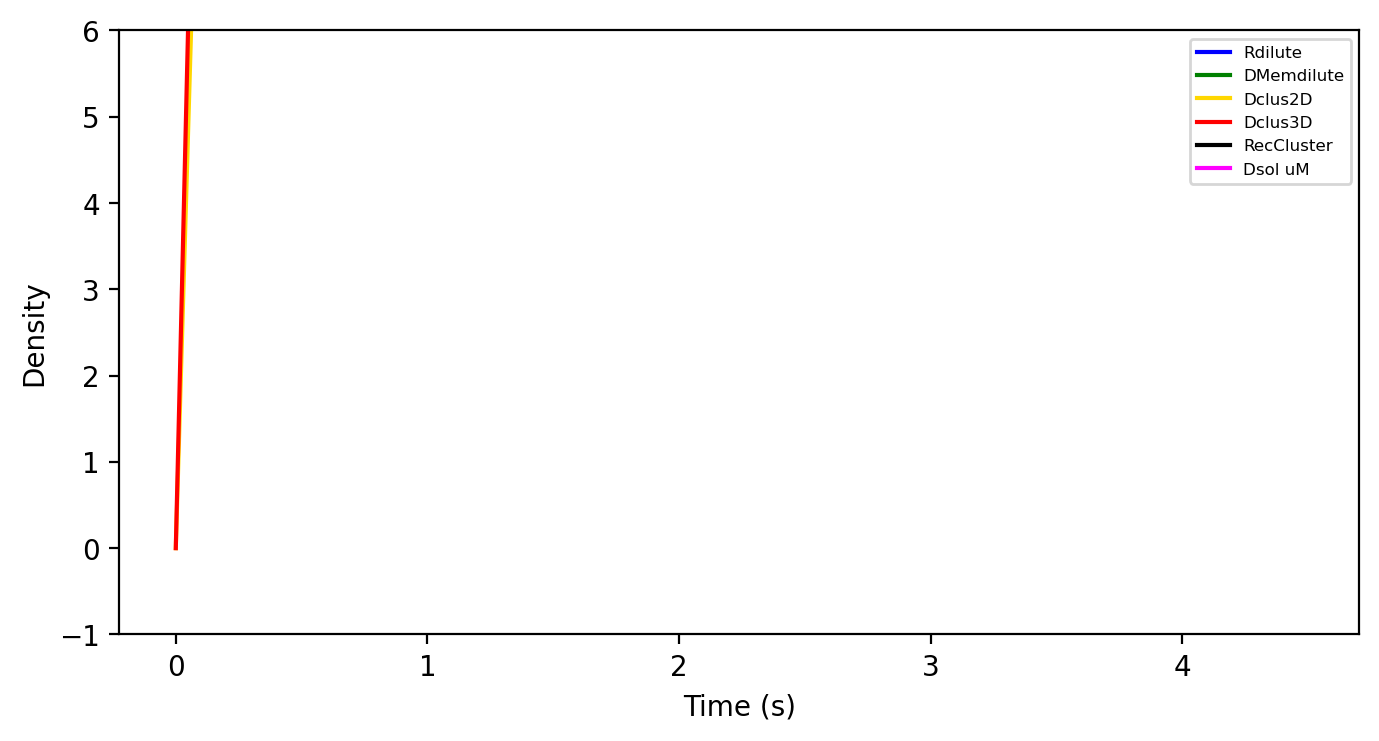

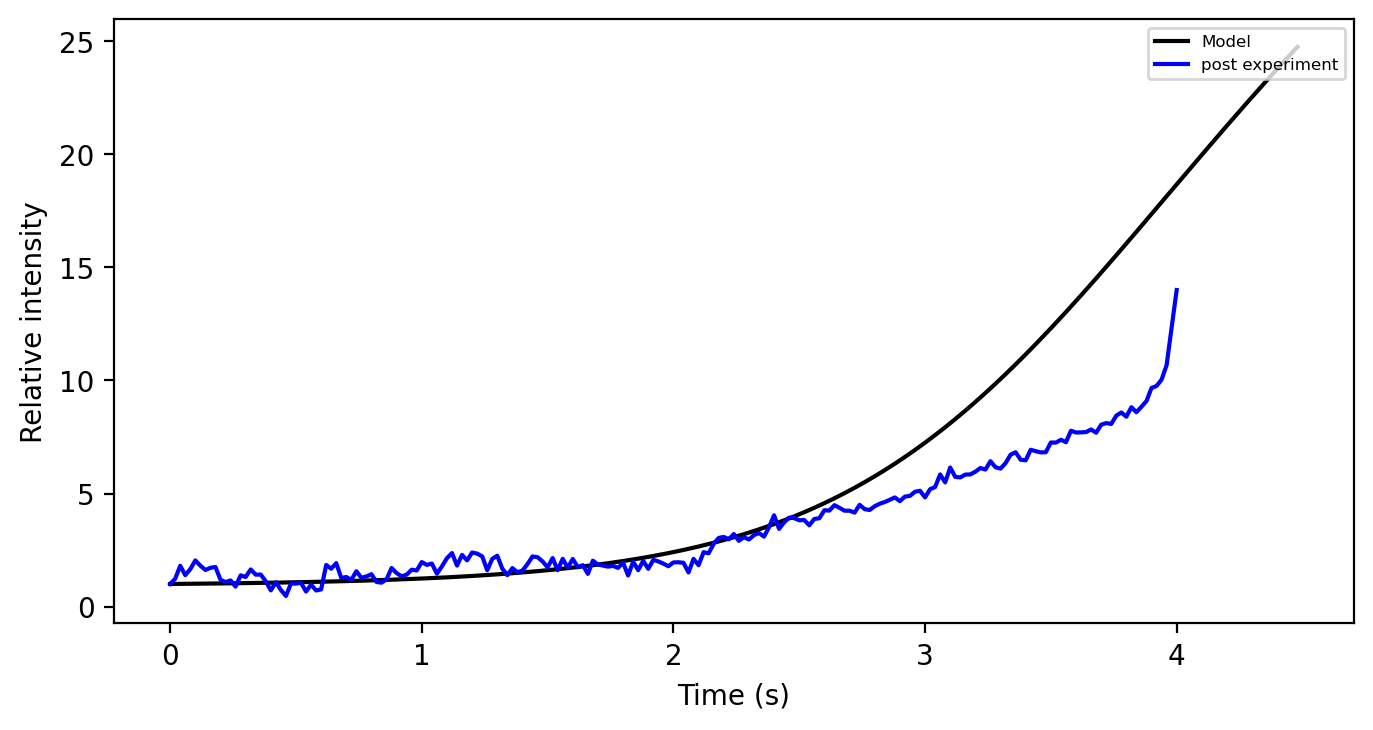

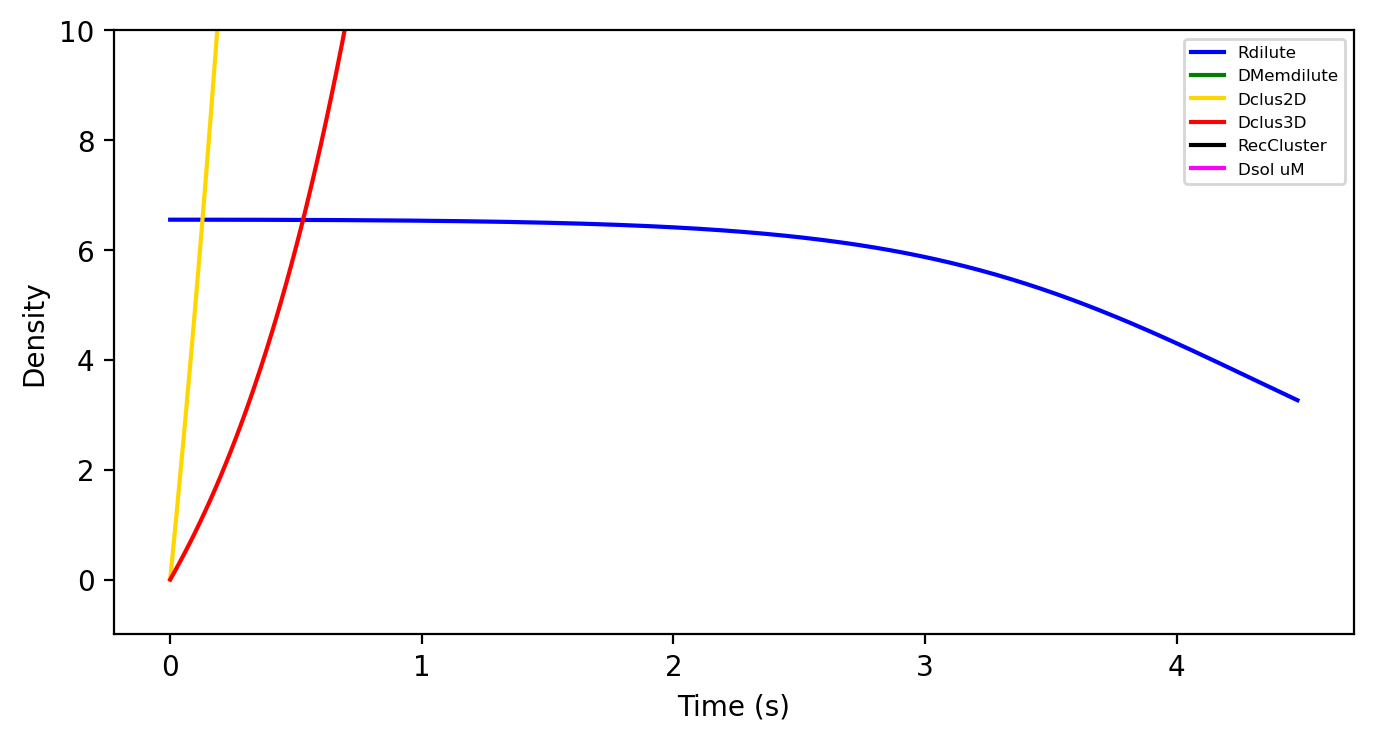

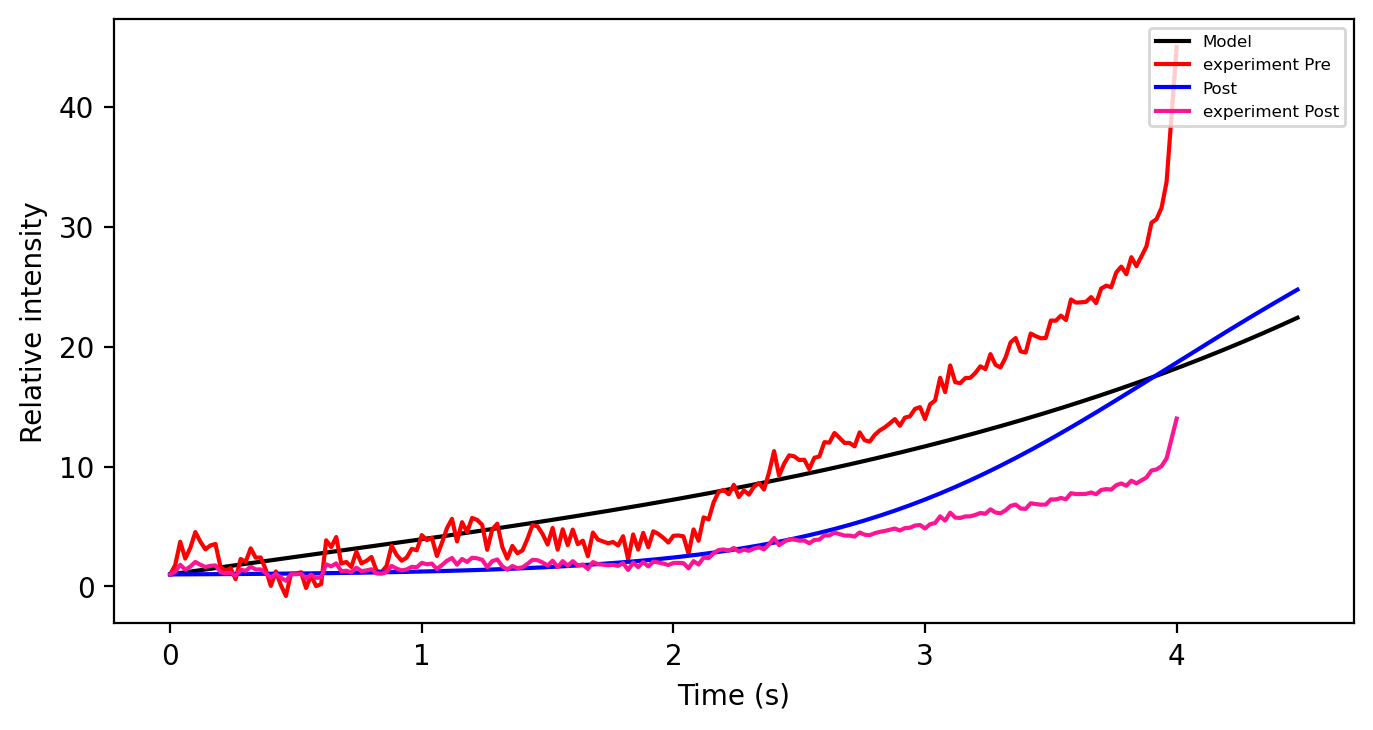

fitness: [-61863.50177488751]
twoD enhance pre 0.8013995878559982 and post: 5.758422732784559


In [68]:

#initialize the model
model = Oscillator(parameter_ranges, paramsToOpt, mode=0)
#define a candidate set of rates
#0.18949941 26.29303259  0.46557607 29.91024703
#0.010988601163145758, 2.513078774626181, 5.719928129816789, 30.058704131310982, 3.4331848621301506, 0.1029389982707988, 0.0006411687796070676
candidate=np.array([ 2.06515731e-02, 6.55374065e+00, 1.54381017e+01, 7.44851972e+01,0.78592423, 0.19185001,7.01618503e-02,1.37400729e-03 ])
#0.8873150757061603, 8.834014135172831, 1.2726364887967274, 3.8456064678128525])
[solutionPre, solutionPost]=model.simulate(candidate)
Y = np.array(solutionPre)
model.plotSolution(solutionPre)
Y2 = np.array(solutionPost)
model.plotSolutionDense(solutionPost)
model.plotModelBoth(candidate)
timePts=model.timePoints
[fitness, twoPre, twoPost] = model.eval_both(candidate)
print("fitness: "+ str(fitness))
print("twoD enhance pre "+str(twoPre)+ " and post: "+str(twoPost))

In [69]:
#V=3.53
#Atotal=1.85
##Acluster=0.022
#copies=Y*3.53*602 #Y*self.V*602
#c=copies[3]/Atotal #Rdilute
#ac=copies[1]/Atotal #Ddilute
#acd=copies[4]/Acluster #Dclus2D
#ad=copies[5]/Acluster #Dclus3D
df=pd.DataFrame([timePts,Y2[0],Y2[1],Y2[2],Y2[3],Y2[4],Y2[5]]).T
df.to_csv("concPost_python", sep='\t')

# Use the GA to find a population of solutions over multiple generations

delIntensity: 1522.6705045454546
delIntensityPost: 1504.9943153846154
Current generation
0


/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[-68938.3238728372]
[-170592.01040278783]
[-173796.3347624183]
[-69917.36628068186]
[-159439.15613734326]
[-174014.43007091671]
[-172696.2221954962]
[-103567.05574540287]
[-340204.74969516054]
[-156970.22054310163]
[-173838.91704138258]
[-174075.492248555]
[-161156.38148520794]
[-131003.29475284394]
[-89961.73645683003]
[-173987.16363544413]
[-63706.66280727818]
[-170176.96227499674]
[-174487.3087406816]
[-174542.40548392147]
[-173641.08667849447]
[-164711.82330877447]
[-479767.59201489034]
[-148618.5273002769]
[-167752.1205226871]
[-109949.21592730776]
[-215285.84174277564]
[-172903.04919704]
[-174500.28202020045]
[-170242.25783668703]
[-170741.32777752812]
[-168769.09350596913]
[-174568.00772539573]
[-165217.69977124367]
[-167506.07204431266]
[-173918.6169241444]
[-149810.37491545267]
[-160771.01881273254]
[-174431.7805827891]
[-137906.110203647]
[-116098.02133100393]
[-174393.6033152477]
[-161908.55459538975]
[-110112.81199194655]
[-394859.3134568494]
[-173956.55702394646]
[-172376.

[-155286.7042463147]
[-170207.1157867993]
[-174042.08946642478]
[-205182.10975077646]
[-174474.119153138]
[-174449.23174937925]
[-109344.47411816851]
[-169647.86771729015]
[-172247.50370947245]
[-173171.1292783275]
[-174132.1396301901]
[-58011.862685672684]
[-61213.34822857006]
[-128540.00309421326]
[-173256.47280615492]
[-133144.26344311977]
[-174470.64998809935]
[-173515.7372856898]
[-173932.02413685762]
[-174548.40979108564]
[-174571.846747293]
[-119416.0370944145]
[-168253.41317901545]
[-166722.48244299693]
[-144374.74641936584]
[-172981.51076669927]
[-174507.9002963921]
[-172513.36578745273]
[-174544.94570589886]
[-139883.11349405057]
[-149410.26594525154]
[-137377.19025756686]
[-171669.76741554245]
[-161500.0724410389]
[-174573.62437621225]
[-174556.5888656097]
[-153287.55016998114]
[-152793.55404298683]
[-174399.72855865012]
[-147650.23397024052]
[-148820.02924895304]
[-174460.89623413997]
[-403607.2706074476]
[-205255.75734784192]
[-171808.54572089147]
[-141182.61769327562]
[-1

[-174178.42039716395]
[-168769.8864569809]
[-168725.04303808694]
[-174098.08586654096]
[-160425.88825961557]
[-118618.19282000759]
[-174299.88756672916]
[-172311.4062102858]
[-170724.6771513088]
[-173939.1505399331]
[-136865.2115182924]
[-338716.15557767305]
[-126346.23219830901]
[-181856.43485432767]
[-88405.26492813148]
[-74985.39836381348]
[-172206.84195037364]
[-168765.19495214918]
[-169972.5001814092]
[-98344.66448070105]
[-173393.43606202782]
[-102112.5153185355]
[-106550.7249205829]
[-239939.12719261902]
[-172554.8571518353]
[-165955.37731288013]
[-174464.73600110566]
[-173687.29342511017]
[-342870.395958869]
[-117799.89912455535]
[-169030.0710121494]
[-127496.76072402534]
[-173283.98653379167]
[-174444.86084346555]
[-167322.14747322415]
[-170851.94379656442]
[-174425.00475484348]
[-134135.98798696513]
[-166380.6774604075]
[-169007.68831880816]
[-170112.5054107269]
[-174414.1781477207]
[-174361.28198571765]
[-166112.8171513706]
[-223838.28800786522]
[-168764.99346658983]
[-16733

[-173663.05774694565]
[-174473.23495020717]
[-163743.7889898135]
[-162632.59794126824]
[-154171.79653949745]
[-174491.21468021823]
[-174496.02924302412]
[-170615.2942168048]
[-173452.85274426398]
[-174385.6354031136]
[-174408.88578338956]
[-80677.89392708172]
[-172138.7964068217]
[-142543.13336917345]
[-153253.39203316774]
[-48504.067635980915]
[-133477.57378184993]
[-174533.00235155024]
[-128344.46448036178]
[-228722.17821134173]
[-173694.07189845992]
[-165715.89138899147]
[-158840.59173878026]
[-173946.6582961352]
[-173693.88020732207]
[-174568.46525983367]
[-173302.72589028042]
[-172346.806288938]
[-111118.57657762498]
[-173835.938222814]
[-483162.4470552753]
[-163634.15955673583]
[-74197.70616316864]
[-154317.02781538048]
[-174551.0121857943]
[-174552.9780606848]
[-173907.55820134195]
[-174489.18801380805]
[-98030.02920763611]
[-174364.9413801864]
[-174537.82875809685]
[-131567.75186589427]
[-173472.0988201084]
[-174213.90453838656]
[-172144.64617387636]
[-118167.51373504414]
[-905

[-143778.31905608228]
[-172648.20085433684]
[-173082.7069868129]
[-313391.1422460483]
[-197914.30404742958]
[-174417.8102232532]
[-141395.5916742471]
[-173818.4353640178]
[-171994.63558133802]
[-168992.19561437727]
[-172133.80650852318]
[-168755.80969028035]
[-437644.6172297127]
[-174538.3915747435]
[-174528.20644161216]
[-171288.2757225635]
[-164033.8655848167]
[-174553.81602115353]
[-159282.11558549208]
[-162606.96323395192]
[-174472.22536576516]
[-140318.80124448537]
[-124978.16338602391]
[-128488.61260537803]
[-168463.89870881056]
[-94571.26763808104]
[-174390.38717206882]
[-136724.08957615675]
[-151606.25972294406]
[-456748.03758498654]
[-174062.2243150673]
[-174544.53997254407]
[-167943.69097414718]
[-174450.45689349447]
[-121258.22164033639]
[-259031.98238938767]
[-169866.1274193449]
[-298058.82347472734]
[-171856.3474562122]
[-97236.66834193474]
[-174365.1870836444]
[-174514.14484371652]
[-132872.33673618373]
[-174136.0777647097]
[-117891.81694143979]
[-174337.98414106935]
[-17

[-172606.98784728028]
[-173361.28481774597]
[-174536.88147462916]
[-148808.46978840602]
[-108409.2505539699]
[-152088.01323573716]
[-174490.15684994124]
[-91796.46086693648]
[-174445.44575071876]
[-174329.77461205664]
[-94983.53232488358]
[-136389.8357795279]
[-174457.38632407496]
[-174032.6142028434]
[-166986.2779331985]
[-129134.0890677812]
[-172876.24321713217]
[-173137.42378972855]
[-174471.57365878922]
[-173665.93337415712]
[-167521.13213174214]
[-174464.40211637315]
[-108591.01241750194]
[-94582.13089640377]
[-144656.77056452894]
[-173688.56447525782]
[-174107.04872979003]
[-172047.4270287595]
[-435385.7409322092]
[-104762.61371459396]
[-117415.38658391773]
[-165313.31457139796]
[-141637.6705530837]
[-174549.8334572253]
[-37405.45248316506]
[-125920.621413899]
[-174131.30408701164]
[-161283.55517780065]
[-174010.25128693608]
[-168511.8507905296]
[-164266.3524482372]
[-174050.9593623586]
[-167448.5718413659]
[-104204.32162919424]
[-174209.70606384968]
[-174532.17076386092]
[-17408

[-174484.63833968638]
[-172033.88787753036]
[-173857.21668681793]
[-174240.86439989443]
[-174063.66498544888]
[-172973.24000989855]
[-159099.35319641803]
[-170775.8583879124]
[-174233.52537634858]
[-171093.3585807355]
[-173134.38178451493]
[-441328.8935620855]
[-174529.40322214746]
[-174360.91740195663]
[-174017.1113484978]
[-174412.48610006808]
[-173446.85055833985]
[-174392.65117408184]
[-173896.54533802124]
[-149187.1133531186]
[-174361.80454920593]
[-174152.50182289537]
[-174545.81354117754]
[-150689.36617051405]
[-174193.1072336436]
[-173958.43875314685]
[-174513.89268877567]
[-172327.15080377032]
[-92655.41937151182]
[-172687.75664790173]
[-166697.56479869975]
[-174315.384971737]
[-174553.2591820163]
[-120015.32145790909]
[-174466.90390520898]
[-162328.56591028473]
[-169368.76755296427]
[-174379.8263398018]
[-173298.29346875625]
[-166807.28986393812]
[-174358.54001629574]
[-170540.83137180842]
[-173719.53916599895]
[-170637.2689018612]
[-173276.44557768578]
[-160027.82581274197]


[-167350.41436468007]
[-173745.97128738376]
[-174514.50524434197]
[-174512.01507751702]
[-146878.31254967337]
[-173891.72633910965]
[-174470.54308989993]
[-100544.80785219722]
[-159924.2859616102]
[-174201.07004829065]
[-172637.2636973512]
[-153625.76984708448]
[-172111.23569246999]
[-174498.5640245297]
[-173872.4099563699]
[-174327.071274328]
[-157402.92838178642]
[-174147.8277078279]
[-132940.60621183098]
[-162891.06361461047]
[-171515.9657522097]
[-120752.84477900204]
[-172355.688871353]
[-150958.99231939245]
[-174553.7035587459]
[-105685.20948800448]
[-173600.37080039812]
[-170409.20458459406]
[-165160.2418679507]
[-136753.06509758587]
[-173764.90411740402]
[-116807.24133225437]
[-174475.22625469213]
[-174474.99139164703]
[-164429.3045470685]
[-174367.09856389897]
[-143173.67507649248]
[-173514.1207519754]
[-168044.79226602445]
[-212237.2376383632]
[-174571.1716453168]
[-143204.2761449661]
[-174366.4746357677]
[-174410.55588531966]
[-145935.2422769214]
[-171975.81769114593]
[-15980

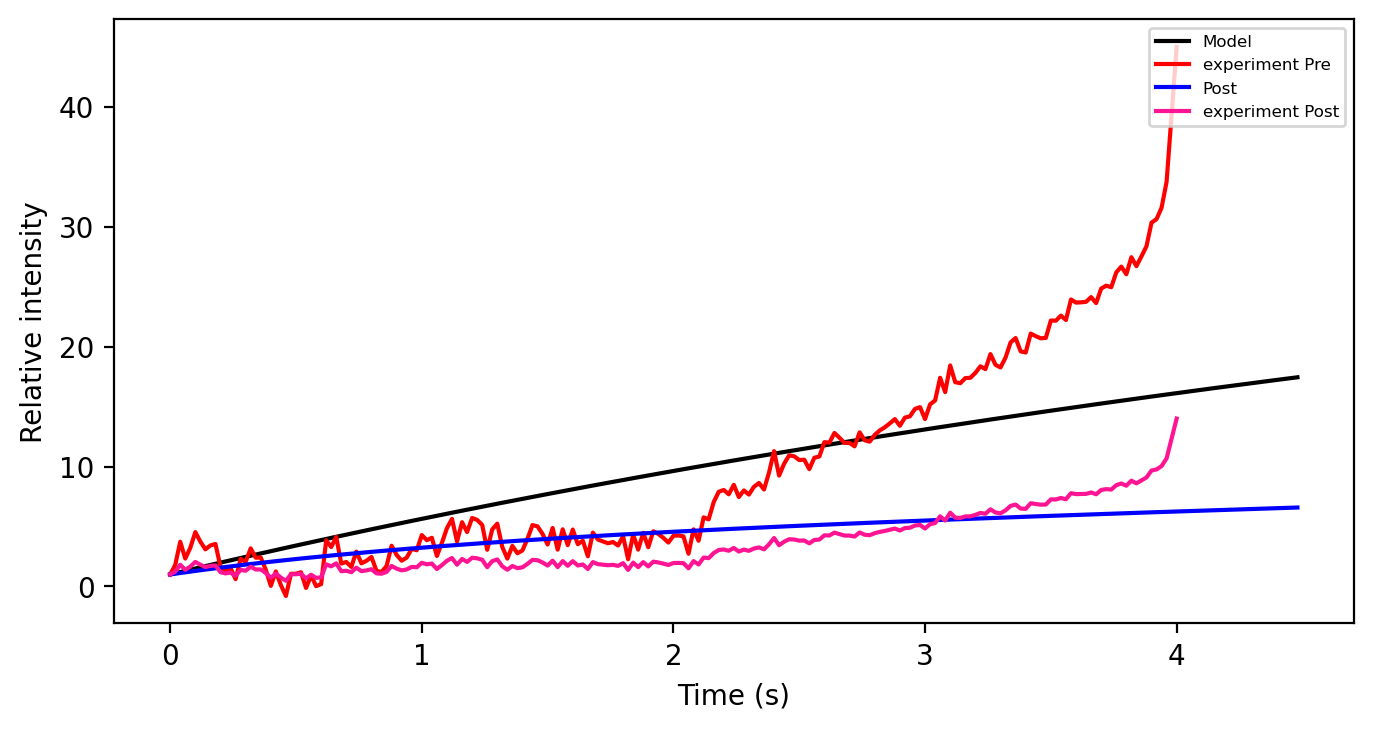

Current generation
1
[-70055.17370127818]
[-95226.85272142958]
[-250878.05264774655]
[-58120.320207922414]
[-83252.43467477805]
[-125824.72246251926]
[-144605.3156277489]
[-29439.30421650916]
[-42276.94785036682]
[-75710.87044051154]
[-145932.552053312]
[-82771.62541817724]
[-65992.65362854613]
[-492970.69247713475]
[-131009.45640333803]
[-38497.07653993341]
[-23520.36813307449]
[-37770.1336743375]
[-59661.7254553558]
[-102754.90246668483]
[-15289.393133813835]
[-83749.1040034019]
[-94342.36225848952]
[-55866.224077473744]
[-17501.01057582728]
[-11775.424952745014]
[-37069.35312877038]
[-132672.69982887723]
[-377146.855511567]
[-76471.44399195045]
[-38555.78918948412]
[-82947.30023231998]
[-31021.82688461802]
[-31232.54601425231]
[-39468.633615105224]
[-122713.68750204296]
[-129982.32848377852]
[-159986.23496262403]
[-145767.7365732289]
[-56631.10340507609]
[-83179.07404152188]
[-72689.46293656336]
[-18692.736347112357]
[-157069.16065025667]
[-23532.33634262299]
[-29439.296797480805]
[

[-32692.56129900249]
[-96844.21255489215]
[-50221.940526079496]
[-48871.75933371968]
[-101367.09917905318]
[-77957.65785747173]
[-94032.3017699526]
[-32259.055659641483]
[-40140.85026370037]
[-55870.39763820317]
[-39977.29830532994]
[-55720.57630817272]
[-118069.16962597499]
[-106783.27353284418]
[-93098.17266092228]
[-82641.25031711478]
[-39306.35746644517]
[-84777.41386980859]
[-35625.062892616435]
[-139476.29340701818]
[-34851.41518511638]
[-39964.06981536391]
[-62309.3992383506]
[-145234.28381296806]
[-44973.62991563381]
[-39071.72307840579]
[-126577.75578527234]
[-88086.38020791471]
[-38965.52480295416]
[-25927.500857426145]
[-47073.67906677554]
[-26845.333075704923]
[-62966.066588215064]
[-48993.1062621865]
[-19555.517273921498]
[-11769.00663630152]
[-29111.759413792082]
[-35293.755512490025]
[-120210.68265529512]
[-342810.66866839514]
[-105245.79845440044]
[-30531.011754166357]
[-25039.66724868057]
[-68086.70851429748]
[-53414.075143748705]
[-60625.08575376269]
[-121542.48798341

[-52866.48292720555]
[-47273.6600516445]
[-295905.9729173925]
[-88194.31644717006]
[-45058.487879612396]
[-97753.94149890414]
[-334418.40807112807]
[-49625.9809344704]
[-76421.8488097908]
[-68438.643238057]
[-82613.70558229747]
[-49444.63831706]
[-37770.66383012899]
[-31924.850568606787]
[-54796.91517180741]
[-42303.20388841818]
[-99943.43613144194]
[-67149.71155395587]
[-67979.93253083507]
[-155088.30520493264]
[-389073.5983253493]
[-170016.55430499086]
[-124568.10186689011]
[-66578.44182379096]
[-69540.72995640004]
[-45813.85305561894]
[-76238.34490814405]
[-23535.528475364554]
[-26210.6472870078]
[-82594.63651851624]
[-45528.50058132986]
[-32501.392454232962]
[-44794.063997112156]
[-54983.507646401995]
[-115202.1003569006]
[-42090.15886904074]
[-117963.85728851214]
[-36848.01243431356]
[-58416.62416798295]
[-33492.493105945774]
[-42372.50260321838]
[-37404.13918583648]
[-23531.780395889367]
[-43422.7856265638]
[-39327.5015812643]
[-83089.33048876727]
[-26236.632275112494]
[-26728.37

[-11762.951432615126]
[-47235.18117127077]
[-103010.94972600514]
[-40908.17631307995]
[-22177.01521756134]
[-23534.04206516264]
[-26655.1453464922]
[-26002.742277865455]
[-141753.7545522248]
[-83323.13543461167]
[-58848.67107048105]
[-58757.33629705978]
[-68914.03067520169]
[-125063.0384184706]
[-11769.002008887062]
[-45717.48826954533]
[-135673.70797240408]
[-26193.603643102328]
[-102171.06284136567]
[-21287.77871061708]
[-123485.623083298]
[-41787.677063752475]
[-42157.804957552435]
[-151822.98944742902]
[-45575.83424788608]
[-33146.06417526704]
[-40234.346655172376]
[-133155.7644380805]
[-211627.36693577754]
[-197101.07123651166]
[-67313.01276034249]
[-98499.43854202786]
[-26789.28460424358]
[-40676.17702558701]
[-68806.55778473541]
[-216355.71468654124]
[-30445.086302989363]
[-53754.621680361844]
[-114280.61645287422]
[-50741.05369851905]
[-77173.06152777994]
[-114199.5595063395]
[-11769.211624233332]
[-29439.12330845608]
[-26231.95263510567]
[-101215.71294292487]
[-78504.892585397

[-116588.89046763832]
[-74161.25818516644]
[-23535.494127361002]
[-45060.95035494267]
[-46066.960875201934]
[-32401.8008931582]
[-44591.867517287414]
[-168910.21508175074]
[-47194.80966915297]
[-31797.874069373545]
[-34902.638559839805]
[-56526.824470167296]
[-40667.4922367945]
[-30212.37618802315]
[-18291.8611735096]
[-106289.15414817056]
[-307040.34705505933]
[-205639.88670561396]
[-157810.66888194304]
[-49799.58596793511]
[-44220.03938069139]
[-191603.92915029154]
[-64547.199541583]
[-51788.47031026567]
[-37399.19044417807]
[-125009.79383932437]
[-37770.241993493386]
[-52453.27165114018]
[-37771.490169213546]
[-58333.59627097791]
[-39695.1880979439]
[-118038.21833075547]
[-17309.62289266506]
[-61047.411822910304]
[-69304.89046994755]
[-29289.741996179102]
[-42566.99295235779]
[-65031.69408961489]
[-87062.43381028445]
[-26989.534610167568]
[-150780.94922514114]
[-52724.3617672797]
[-39759.36831919437]
[-60274.00296848343]
[-91849.37153162263]
[-85573.08000192337]
[-147537.04890265694

[-275726.3160175165]
[-114760.6689276171]
[-109933.26778257746]
[-101444.93628439384]
[-31698.33967905499]
[-147246.36016257858]
[-92319.51963529151]
[-103395.93418863084]
[-65855.61506718304]
[-76465.82170038452]
[-198859.69823733962]
[-42327.839023679466]
[-58949.086396422936]
[-46421.22297418073]
[-47301.568327424146]
[-64390.77205243234]
[-50042.062067574516]
[-30352.198391319576]
[-27125.306634823428]
[-39749.25427780836]
[-24231.576883618356]
[-125601.34426918355]
[-108336.46907744734]
[-42436.200996155145]
[-52040.4030899559]
[-323705.305467606]
[-36504.5782639547]
[-29439.301941057267]
[-50680.57660004464]
[-39467.94670310662]
[-54359.155027745524]
[-19678.415375866363]
[-153061.4875848072]
[-49352.30134917813]
[-11637.451267395641]
[-296201.8888713475]
[-143198.83922404674]
[-138009.1964098501]
[-173054.5793940943]
[-98371.03627639363]
[-48476.42141336785]
[-48026.74750542772]
[-26764.32819464474]
[-110476.97352944553]
[-87884.10532864244]
[-33893.11941259402]
[-45609.92465572

[-432896.34664522833]
[-47982.48788692584]
[-95421.7741828819]
[-121100.26998157948]
[-42230.89690279953]
[-52165.13338942149]
[-112852.65288916268]
[-96370.76657483556]
[-48577.41053278363]
[-51119.28787819951]
[-57996.31344364863]
[-33252.59776546593]
[-53275.28985918473]
[-34086.76719376026]
[-109593.03997994597]
[-99668.70274921122]
[-219237.0586274406]
[-31925.416777005223]
[-68762.4135718185]
[-146912.79905241408]
[-98846.92322476735]
[-56353.237424198305]
[-38715.24809219033]
[-25015.63278437042]
[-39327.44506217695]
[-150222.276222434]
[-20720.266778742207]
[-38964.455765739884]
[-43483.077218866994]
[-60079.71341236207]
[-90361.65418706821]
[-137442.0597360946]
[-24494.352249888987]
[-101512.55624130458]
[-61989.81597378399]
[-34175.63970492666]
[-57273.09995463492]
[-45606.46879868272]
[-105826.50078489532]
[-60722.11462801313]
[-70226.58231504384]
[-69879.58428007769]
[-38798.8845685725]
[-56058.3914635075]
[-34136.702399327856]
[-108389.50099352488]
[-48739.165852873586]
[-

[-43192.0213959606]
[-159734.39935428702]
[-113894.32742521813]
[-22963.838785725344]
[-114919.91083569056]
[-38159.13544775729]
[-60612.41524916497]
[-163179.33075142832]
[-48841.39965099178]
[-56275.71949586533]
[-49976.78385704801]
[-65676.51348968776]
[-26638.08758214214]
[-26343.835543000554]
[-84793.11266365988]
[-52850.242339304896]
[-119624.01125159147]
[-151393.9749709192]
[-143161.991302599]
[-380938.3536702587]
[-107730.71336705978]
[-42292.2562698453]
[-23495.434577332264]
[-81223.14527063743]
[-96091.04718928336]
[-30691.729907024346]
[-33033.64305979472]
[-55802.59466546452]
[-278522.6055723444]
[-65781.2402846979]
[-12767.911518286563]
[-61777.48016377574]
[-47355.363782024244]
[-38667.318529840835]
[-58993.904949903896]
[-39345.01216515792]
[-66980.19279232966]
[-354868.1048081316]
[-87020.53115116648]
[-26220.755037444695]
[-32989.5376577741]
[-11765.320567889132]
[-58566.32029960785]
[-36246.28570104047]
[-57294.99773473531]
[-37147.59388569748]
[-37770.17179384079]
[

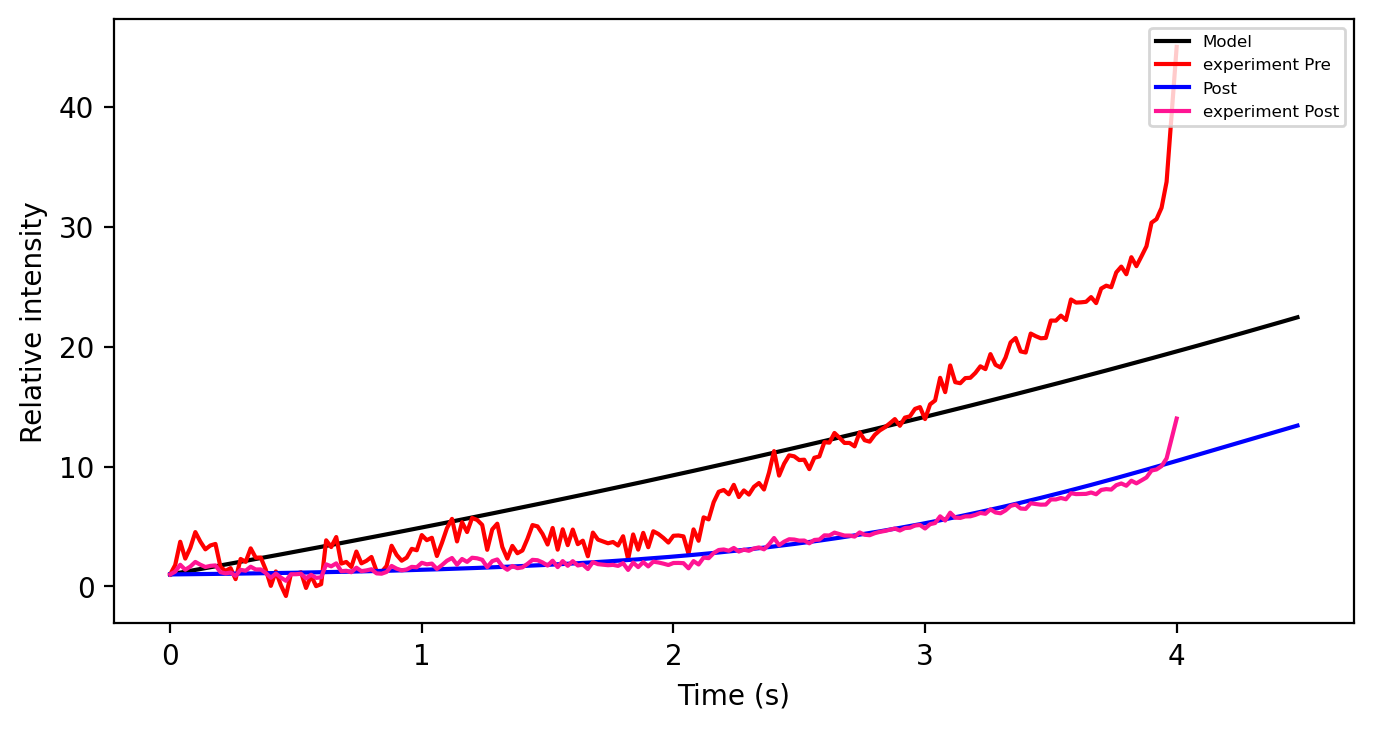

Current generation
2
[-66021.28770454951]
[-132939.427201914]
[-11650.156638754399]
[-116406.86919368414]
[-35026.94424827257]
[-14204.696648045632]
[-11659.950385210412]
[-31468.217532722425]
[-16310.637864423508]
[-22153.626438632757]
[-143814.51211737175]
[-61256.97629213608]
[-22086.1429493807]
[-43780.15210356636]
[-37901.56771922056]
[-45041.76056673885]
[-11696.197215291892]
[-13356.680131355446]
[-34283.316716930116]
[-45138.894874677004]
[-18543.118415164732]
[-12253.706028225164]
[-23349.321576805643]
[-41563.41568617246]
[-38356.97868372913]
[-52215.50007196123]
[-20219.295266126923]
[-43908.71447417939]
[-48717.871167963116]
[-11386.494536080543]
[-22621.03516233476]
[-11595.978889787211]
[-11775.451755990041]
[-69699.27218815201]
[-11606.41319815879]
[-11466.592655514853]
[-23260.582529332292]
[-18842.123751992465]
[-36650.945322103595]
[-89764.66873581373]
[-48723.55380021555]
[-11767.71585986473]
[-211332.43006592753]
[-95951.26394814056]
[-24099.80792515674]
[-15719.337

[-67683.21255296796]
[-11695.549777515012]
[-13808.927140648026]
[-15465.142203497817]
[-82624.28766926221]
[-11768.237434525916]
[-11769.193896886727]
[-77911.32346030865]
[-15331.707395948013]
[-11759.954627905132]
[-13766.972942051785]
[-10997.507658016859]
[-11770.066393812462]
[-48708.57488058321]
[-108897.8758617184]
[-28051.674620041656]
[-83509.07684801792]
[-55486.706832262505]
[-11349.00078658494]
[-37398.834925337855]
[-107623.47105715395]
[-44987.23531392121]
[-13434.21786136293]
[-74073.40276747593]
[-52854.27636789474]
[-19944.1205741237]
[-12171.701855430983]
[-16955.60303946341]
[-11768.26997443795]
[-12338.410015971003]
[-104123.02716838164]
[-30597.954640938548]
[-21330.12402825431]
[-16802.48700074824]
[-19150.94694829604]
[-10976.043080011792]
[-34960.28079353278]
[-55825.72112592307]
[-345161.80962698796]
[-75827.10041697585]
[-11771.599927110457]
[-68802.74574453184]
[-337833.8143930591]
[-11767.659724963129]
[-33354.671137996855]
[-15097.530796965748]
[-49053.235

[-31239.49536421017]
[-68593.59489754797]
[-11614.157877331756]
[-168738.3397420541]
[-14727.126619346234]
[-87589.48819265497]
[-155772.27006712064]
[-14693.185304611727]
[-11765.83550364371]
[-65608.25015123023]
[-12161.550070196376]
[-10971.256359141033]
[-29077.0913143586]
[-41791.396019525004]
[-12258.905070919704]
[-14786.163041841271]
[-10972.636561252173]
[-46599.7589933172]
[-112391.3471172239]
[-53619.641871805405]
[-22881.98256723403]
[-99290.64644267126]
[-56074.531455865384]
[-25388.716787354853]
[-18759.438190665052]
[-10748.796946789695]
[-11167.988453384445]
[-32657.46168078766]
[-11768.547183248464]
[-119587.07132679322]
[-11769.669434135729]
[-74362.24948622816]
[-10973.632429208548]
[-11181.993447166893]
[-46793.69226382948]
[-23735.620436930298]
[-45911.163151053406]
[-22486.46439994668]
[-11766.538904296733]
[-11539.562027071333]
[-11766.395133463437]
[-11765.994702805538]
[-120456.13996202321]
[-35150.341797748406]
[-75085.16969577505]
[-50517.992166724915]
[-2198

[-40124.4654869696]
[-185615.70686422155]
[-18503.715082929077]
[-25280.937349779706]
[-53664.157401070464]
[-20669.33959775773]
[-20578.374612724598]
[-11770.809060575368]
[-11765.040322282586]
[-31863.119335671094]
[-20584.213500349906]
[-99809.7677385743]
[-11880.604427222721]
[-51981.937606603016]
[-71577.58974119887]
[-12736.842503022104]
[-25444.751034624845]
[-13376.464757681892]
[-116580.9733585738]
[-32145.42996563144]
[-63779.98458255287]
[-87859.54147783581]
[-21266.513503950948]
[-46954.77193728072]
[-228104.7748938448]
[-86472.50729745507]
[-17361.417590209265]
[-11658.423561248093]
[-14605.973897866043]
[-17076.75719805413]
[-16366.735599338594]
[-11463.559861143658]
[-93352.68884809138]
[-11279.824170984823]
[-49728.99088222273]
[-342996.8512380353]
[-17492.052115764316]
[-24516.036698147378]
[-118959.00503303613]
[-12340.409525656092]
[-18222.159156031797]
[-16197.731672767557]
[-22470.946322597854]
[-12281.721544637552]
[-13997.083443063626]
[-11765.714515940941]
[-106

[-54566.421903213726]
[-135786.74085869943]
[-47502.92382213398]
[-11466.866405467532]
[-22371.367428475147]
[-13369.92305871523]
[-127006.57244291199]
[-35164.48980001682]
[-50187.46942480439]
[-153340.38551968875]
[-13013.872049573454]
[-121109.65739361648]
[-39303.23514501076]
[-71469.64354639794]
[-13824.811351109121]
[-11765.520002257083]
[-15445.929478053582]
[-24072.440920438814]
[-18494.17400280316]
[-11656.207596195125]
[-88838.99936605417]
[-15730.796735632863]
[-38157.41062942604]
[-165528.45339795138]
[-171469.6803486204]
[-13548.922754357573]
[-11765.063784953183]
[-305257.44985092344]
[-57949.62653902178]
[-51811.89867989799]
[-37239.24217278855]
[-79665.33762281624]
[-162932.58216104706]
[-17453.233740398875]
[-52758.66043115826]
[-125022.30919164338]
[-34850.06346687714]
[-11755.452074407973]
[-10896.101910409758]
[-33195.54029182167]
[-34317.82303706222]
[-11912.928700381677]
[-20551.52220593478]
[-11606.921295101562]
[-22814.112426694755]
[-21428.49435681683]
[-14384.

[-17955.306479161758]
[-24213.627411092966]
[-101551.00573787706]
[-32317.51582881235]
[-11768.01695395112]
[-10878.729244935823]
[-18649.50773477828]
[-11643.489817249727]
[-11630.692375544777]
[-20332.293252492105]
[-13980.838124526785]
[-11767.917183397889]
[-178069.73144570368]
[-169406.39183389445]
[-48732.97102262819]
[-14916.11089003493]
[-11913.924002391082]
[-51671.295600153615]
[-59309.37218695532]
[-11767.93048144341]
[-11767.13379237165]
[-334610.9557581467]
[-31929.23597384819]
[-22649.911214922773]
[-105027.25707894287]
[-11770.294424667854]
[-91887.38280084883]
[-14567.459060447325]
[-47892.2301525938]
[-73144.62759927235]
[-14810.933815333783]
[-42184.923272133296]
[-186693.7075582919]
[-13092.231361068298]
[-22235.674409295345]
[-11464.608910451543]
[-12250.456150270538]
[-23632.455689778595]
[-13439.657668804279]
[-73775.69065875858]
[-17368.44409808339]
[-17715.907475246127]
[-20911.92563265927]
[-14743.380220745194]
[-29023.25949794279]
[-34181.44811643341]
[-44476.

[-67404.44714957789]
[-33181.37914588503]
[-34600.90966800968]
[-73011.24784989681]
[-22720.293308406377]
[-13361.55287230185]
[-46156.221081360054]
[-39024.209352334816]
[-20073.710365099214]
[-21440.508728701854]
[-14741.071884304936]
[-45257.35727028835]
[-11761.66987641835]
[-12276.189215886745]
[-16856.598413017986]
[-20023.457650254764]
[-18264.133726379743]
[-30024.877867821095]
[-35689.21918230601]
[-12231.403225871642]
[-10973.947937222962]
[-26090.1568901653]
[-23491.15684478537]
[-26567.660778584028]
[-80096.79437299084]
[-17376.60089969131]
[-17747.960351774687]
[-156374.59866632146]
[-30663.02153484799]
[-81396.95458951152]
[-25033.764506953295]
[-48920.931170714044]
[-72534.01470222844]
[-31951.507534661716]
[-87624.1540083643]
[-41470.28500130294]
[-20073.813312293372]
[-41188.3768866548]
[-102189.01690175326]
[-314362.0205696078]
[-127278.79395382555]
[-120608.58836759179]
[-31412.764350886726]
[-25841.478303643024]
[-11765.981968094278]
[-23173.524650585525]
[-15813.41

[-33049.98838518701]
[-19270.476229568652]
[-13563.81574640783]
[-152995.2965086356]
[-12034.153732781242]
[-22910.664564265353]
[-147868.6978229222]
[-261869.90729075918]
[-79225.36868557273]
[-20372.526281121078]
[-45845.15675957939]
[-14928.711502631162]
[-79685.1924218572]
[-20515.598486219656]
[-43038.895386718534]
[-11606.989742518668]
[-38970.071635204666]
[-68078.1278053321]
[-14215.193774624571]
[-11770.226039507826]
[-60293.57678147026]
[-22365.883940949043]
[-11599.996910110707]
[-76541.30895629847]
[-95204.4232895017]
[-117964.90815025229]
[-95834.64709764726]
[-66259.70988373645]
[-59665.170784690315]
[-12328.357611876976]
[-12766.56428479347]
[-73085.7295517866]
[-20777.566840122563]
[-25509.902338670527]
[-12998.465909900831]
[-11786.257910128767]
[-38592.40810991973]
[-23156.835445032986]
[-26491.1551223548]
[-87946.87285523367]
[-13734.2131290086]
[-56394.08088906387]
[-60505.439691728316]
[-11652.553031381136]
[-22124.456459823778]
[-20163.059836437787]
[-13896.687756

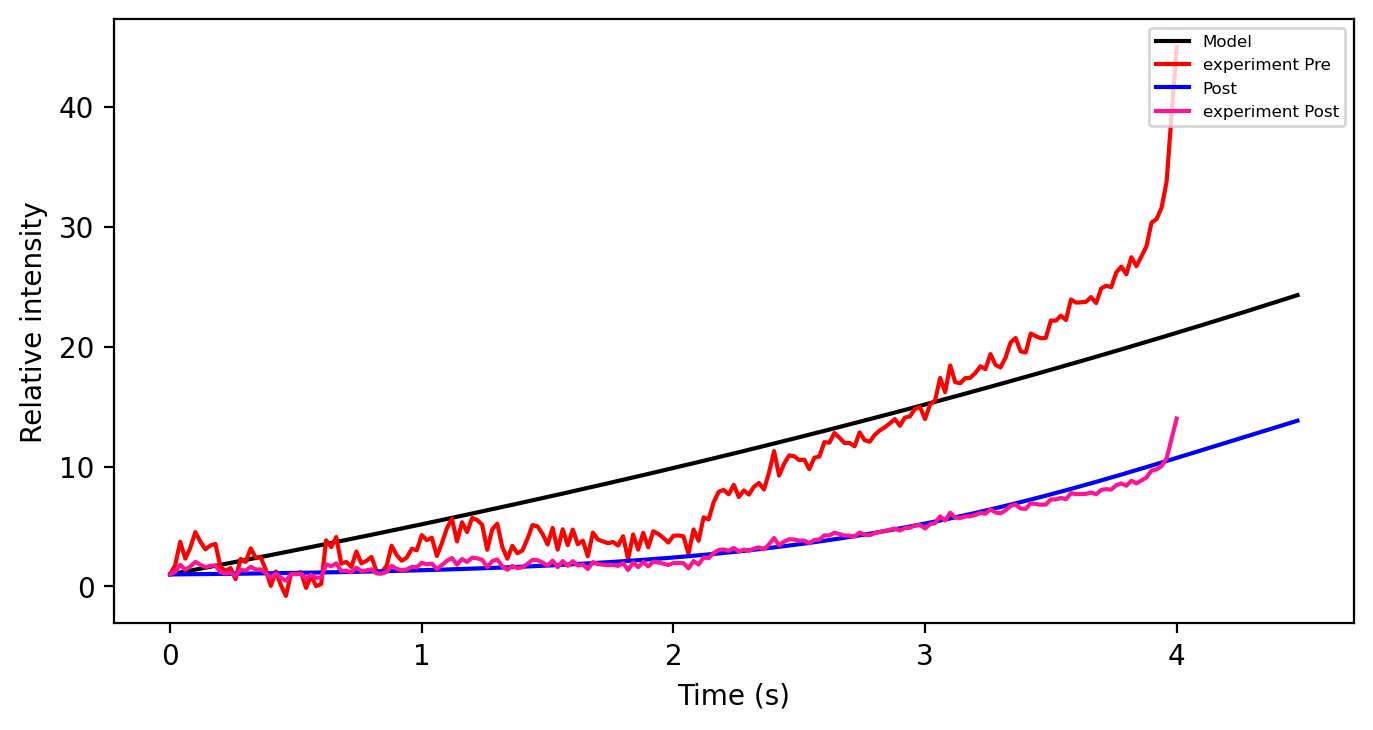

Current generation
3
[-19970.73923079113]
[-83610.94861030452]
[-11104.33467690872]
[-10825.748130411417]
[-17646.783012140164]
[-253609.8266156782]
[-15345.572363921718]
[-37323.51817855639]
[-21525.753012497084]
[-65386.824103396655]
[-18375.544662984597]
[-10881.97142242012]
[-12259.52262146804]
[-63462.65010747653]
[-23898.593751955013]
[-20459.906742935855]
[-13894.61732159591]
[-134358.7360803294]
[-11219.82258624269]
[-21058.327395087792]
[-34496.063280443384]
[-12786.201841310725]
[-151623.6680716128]
[-55352.257983526695]
[-32076.45472861356]
[-83299.03958188405]
[-41725.779054136154]
[-18810.025592368165]
[-23141.4935412765]
[-18646.384651145785]
[-10878.251238753459]
[-52576.55621928407]
[-54817.02030485445]
[-14340.731084151044]
[-16522.56877332]
[-11135.828123488765]
[-10971.43364699239]
[-14376.586914110683]
[-90442.27489745626]
[-10967.09175385456]
[-10969.320735400293]
[-39495.364180323304]
[-49625.58374947006]
[-66213.79985179198]
[-10972.484300672542]
[-32801.00388538

[-41689.23962527976]
[-90812.62450271855]
[-49194.236272302194]
[-34767.42889784979]
[-253220.2021745494]
[-59605.47576356545]
[-136589.6605422971]
[-62083.50686273833]
[-178196.86881170556]
[-10763.274700187772]
[-69070.66528194209]
[-57800.981888392365]
[-34411.52234008293]
[-17383.480281178017]
[-41426.193438209666]
[-21894.17561910357]
[-117355.96054024078]
[-53640.49288920448]
[-19381.955306411444]
[-11315.695998834766]
[-35078.33609367715]
[-77507.3729096714]
[-30514.83489274686]
[-17844.83610651998]
[-38448.31601244792]
[-13229.720073847075]
[-45344.73385351253]
[-52910.43639474252]
[-96824.53045336685]
[-18722.96618729509]
[-10930.468680231203]
[-18946.4897104243]
[-405998.77210374625]
[-86727.07165183511]
[-201965.3979954185]
[-60741.140225327756]
[-11281.452022753661]
[-174456.5698998395]
[-10818.678090606245]
[-10972.514337128467]
[-28985.50093470294]
[-137797.91230050998]
[-93759.62930193129]
[-156617.9272769222]
[-46836.42024314537]
[-20172.21648292255]
[-32894.26427740751

[-61910.372601972434]
[-13450.32651724113]
[-11189.626790126988]
[-20573.299415954032]
[-112014.76167453332]
[-23518.459082869973]
[-10969.684416397147]
[-189333.19204619815]
[-55953.7559408751]
[-175672.45986360178]
[-21140.411782483083]
[-73345.31334349174]
[-20564.770581495377]
[-120377.7781541952]
[-25182.498562374978]
[-58501.2199018963]
[-10971.374187745547]
[-70719.99484522676]
[-11116.680279015929]
[-10930.762651236215]
[-12439.832658557165]
[-21405.04196085962]
[-43125.740848357666]
[-77212.48600825125]
[-129557.04972529456]
[-18463.633782850266]
[-34438.91868275871]
[-30111.95111750158]
[-25059.74961826964]
[-41271.70762426175]
[-29195.914842014165]
[-44287.05986268039]
[-84941.50034951442]
[-52234.904479140445]
[-10948.755035634218]
[-26235.61108866298]
[-15544.610630444791]
[-33532.923564203695]
[-36343.27062300654]
[-10750.457750340276]
[-16887.189610854195]
[-84414.10879731219]
[-119703.98935981203]
[-13158.177972075884]
[-10746.664263066896]
[-93776.5797418967]
[-10972.7

[-29669.866819298208]
[-46882.15867716195]
[-15186.539355024572]
[-45541.868190996254]
[-27420.799938167103]
[-82895.20199132062]
[-10742.591242092793]
[-11461.0418901794]
[-23983.554710536067]
[-72192.1363761924]
[-72224.53777414147]
[-77066.17592875854]
[-10907.91342468977]
[-58167.27336205721]
[-13329.518286414937]
[-10974.595612534724]
[-112505.21540265533]
[-11223.944666814588]
[-11034.755818119631]
[-42514.610673465504]
[-86319.86342884685]
[-10909.942788432994]
[-18688.147999287343]
[-36040.33861537942]
[-12612.422497126066]
[-17338.544297160908]
[-23211.33248926542]
[-21147.028750998477]
[-14003.976247044948]
[-77696.16654880701]
[-17474.69781553932]
[-42438.696403886875]
[-67985.71200012254]
[-10817.865882396203]
[-10969.121576354832]
[-12599.784078768827]
[-44941.98944404475]
[-10963.256620968274]
[-12771.537416760271]
[-39488.227183029856]
[-46515.230691624565]
[-82587.19471018892]
[-49398.8549753126]
[-17283.82030334275]
[-64573.287667116834]
[-10914.256732091602]
[-16966.9

[-178251.6114973543]
[-42262.278377378476]
[-57015.724809167186]
[-16435.525368298542]
[-16815.81299868486]
[-11398.494425186509]
[-14662.566773492737]
[-56746.61554312948]
[-40983.736155613486]
[-58545.1607539206]
[-13794.076103531883]
[-14548.121478991368]
[-17699.74235839692]
[-43585.71882290445]
[-20700.59505642733]
[-17069.075423539653]
[-25697.439008142333]
[-14232.572965241725]
[-59038.88844279271]
[-10838.974720837585]
[-41498.30668988025]
[-18308.589217132452]
[-20165.40323270878]
[-59788.50762162845]
[-12935.543844915283]
[-40660.08478445531]
[-11196.12896541503]
[-12721.226894608812]
[-142648.89599457194]
[-22232.475201370624]
[-10930.813599365689]
[-377444.4731125317]
[-12574.30856624373]
[-21918.530279825587]
[-19617.64865656782]
[-104028.59659196998]
[-89721.51228294364]
[-42658.063126354136]
[-105039.247488437]
[-16201.154867079167]
[-86835.46197086383]
[-101446.62310303346]
[-33728.79916036368]
[-21054.508418111203]
[-79489.59825050307]
[-51424.40601011165]
[-111694.730

[-10818.150772586698]
[-241103.62752929135]
[-70387.24513422599]
[-90140.37022436391]
[-34480.09680559712]
[-43079.97289535245]
[-35084.57558745638]
[-19665.97042156259]
[-21352.900668689406]
[-62542.728824481586]
[-32689.506435971496]
[-16240.407034893093]
[-12813.225494199316]
[-11116.48031044182]
[-116847.5621459473]
[-81497.85715981589]
[-16329.797028907582]
[-30284.183334439003]
[-40551.574973266004]
[-228346.19967656632]
[-69177.83266626207]
[-16838.49444780086]
[-17850.03436093306]
[-23652.53468144246]
[-52675.37983633208]
[-10892.771603050578]
[-13347.988026596344]
[-10970.853903827465]
[-18363.369450563787]
[-13281.528559800052]
[-10972.782409331146]
[-71723.57156887272]
[-94872.88701514745]
[-57276.66418354718]
[-55009.705830164894]
[-34793.77402379732]
[-11967.594523818423]
[-11144.426225829753]
[-15097.86278166726]
[-130005.0687510868]
[-93904.39199652913]
[-10875.669646095195]
[-10748.446353751344]
[-11760.070120747756]
[-11024.109183896267]
[-19564.17274906321]
[-52661.13

[-10993.682977590177]
[-62263.85168055835]
[-19393.972314908635]
[-32779.082137473306]
[-74538.53847821426]
[-15499.583164105641]
[-37215.25991021696]
[-19530.836002020238]
[-16838.88456487278]
[-11884.424825474805]
[-41652.42396000071]
[-17993.673800745437]
[-10975.454397696065]
[-12328.56671225889]
[-60200.044654413956]
[-48332.076199561256]
[-11040.754819835063]
[-25151.199442342586]
[-11928.635327257474]
[-11676.172005595285]
[-134673.3637089171]
[-53958.59574206457]
[-21715.18920797357]
[-74645.17056250882]
[-47101.00881770282]
[-45532.48663553726]
[-35637.23393177709]
[-10876.630010745179]
[-10837.985167502376]
[-52935.959270163556]
[-137893.82642746283]
[-20633.01998550572]
[-15325.44147558429]
[-36500.7202021064]
[-68476.49962914397]
[-15716.858482628977]
[-138560.19138213556]
[-16635.91685286216]
[-10810.704944869289]
[-16611.192394328697]
[-10971.59040767694]
[-109887.31227355213]
[-31208.361861517213]
[-72357.31415590738]
[-10899.339488474878]
[-11342.101625798316]
[-101429.

[-144703.65867690856]
[-63198.8367070154]
[-13639.31121687405]
[-459017.8421743375]
[-101760.88513392421]
[-25679.19071930962]
[-87298.06696451017]
[-206973.01717030688]
[-75655.5612493599]
[-40601.65366418315]
[-50767.193199985704]
[-10810.520007410722]
[-428998.2969732615]
[-17648.026396113113]
[-11276.395680449617]
[-10879.86405436848]
[-97715.18506322232]
[-50003.53457246821]
[-395381.9432178818]
[-38087.44048062597]
[-10976.097600028563]
[-44273.67943504368]
[-66400.16592150947]
[-41637.91190567721]
[-80667.47817419145]
[-44165.20761711006]
[-22856.83538866376]
[-11422.63006081831]
[-11490.491706757239]
[-14676.293001078187]
[-18832.145677723627]
[-159966.04918322494]
[-10995.392334862976]
[-126291.12883188196]
[-20237.94893357173]
[-19243.180125554343]
[-36748.59022520017]
[-10924.08973751869]
[-11961.318300784895]
[-10894.74364725269]
[-12556.505977010389]
[-24765.149253548196]
[-13662.31321157672]
[-18555.864739925884]
[-15712.788547685082]
[-313284.38436543854]
[-25883.6834545

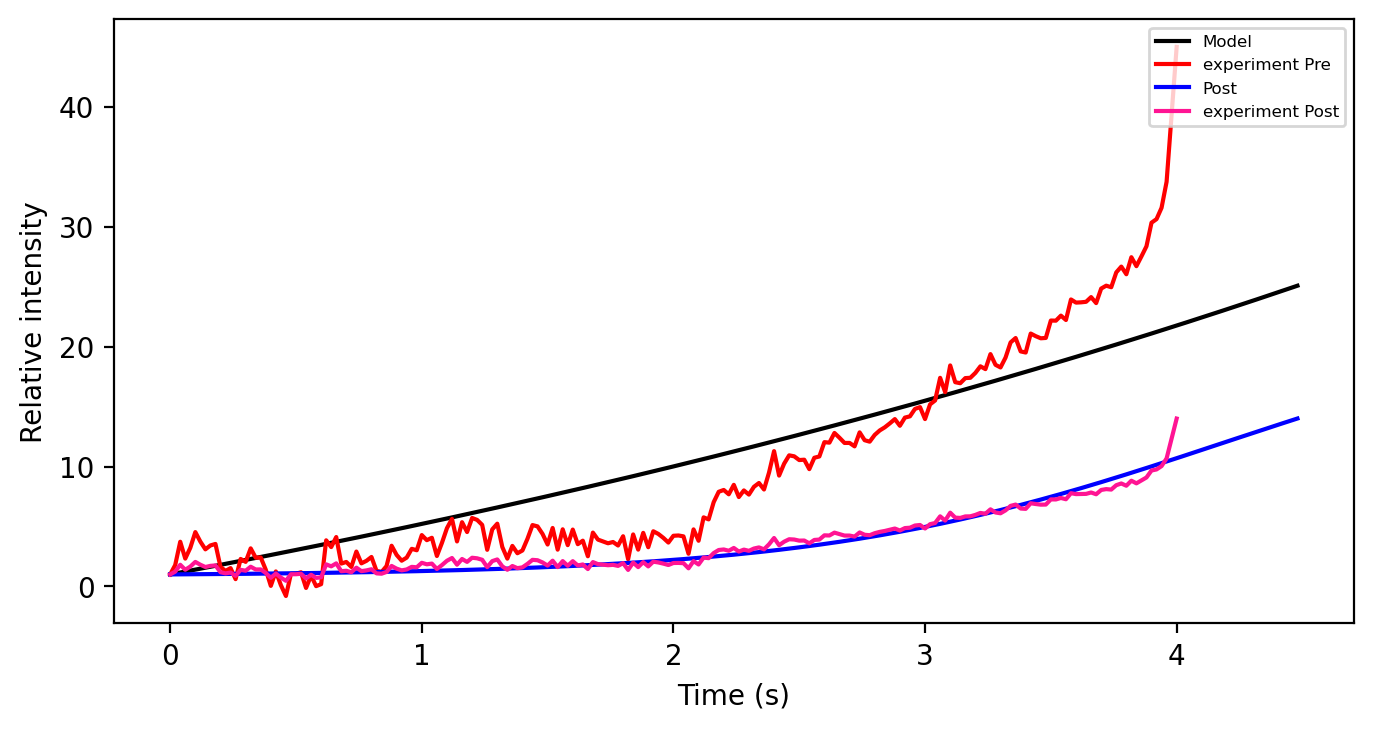

Number of viable points: 11086
viableFitness[0][0]: -68938.3238728372
viablePoints[0]: [0.0620839106839891, 122.07307266073282, 0.5, 22.75284515118913, 0.28850798545289325, 0.16059149843085396, 0.0014178319960322905, 0.3360779705478256]
shape of viableFitness: 
(11086, 1)
-499878.1475432792
Best solution from initial sampling
Length of sortFit
11086
-10673.026091305765


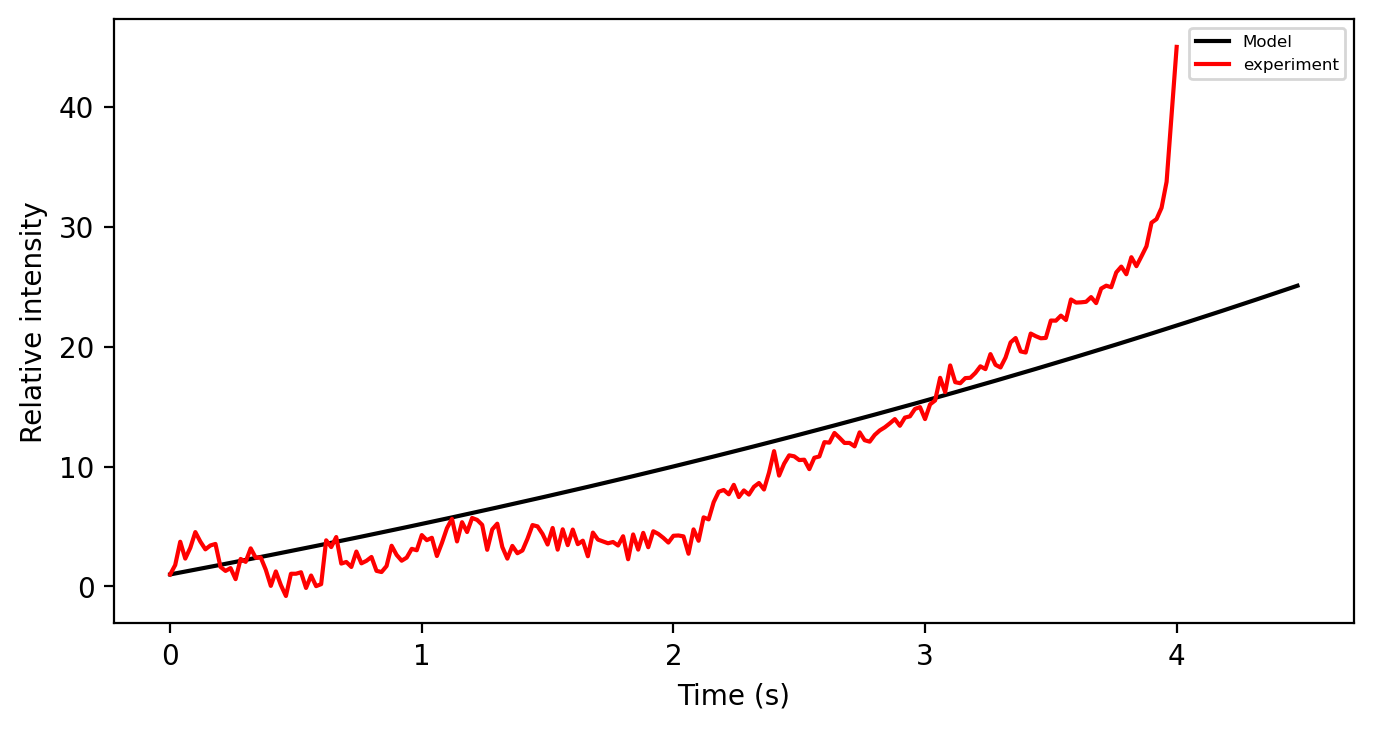

WORST solution from initial sampling
-499878.1475432792


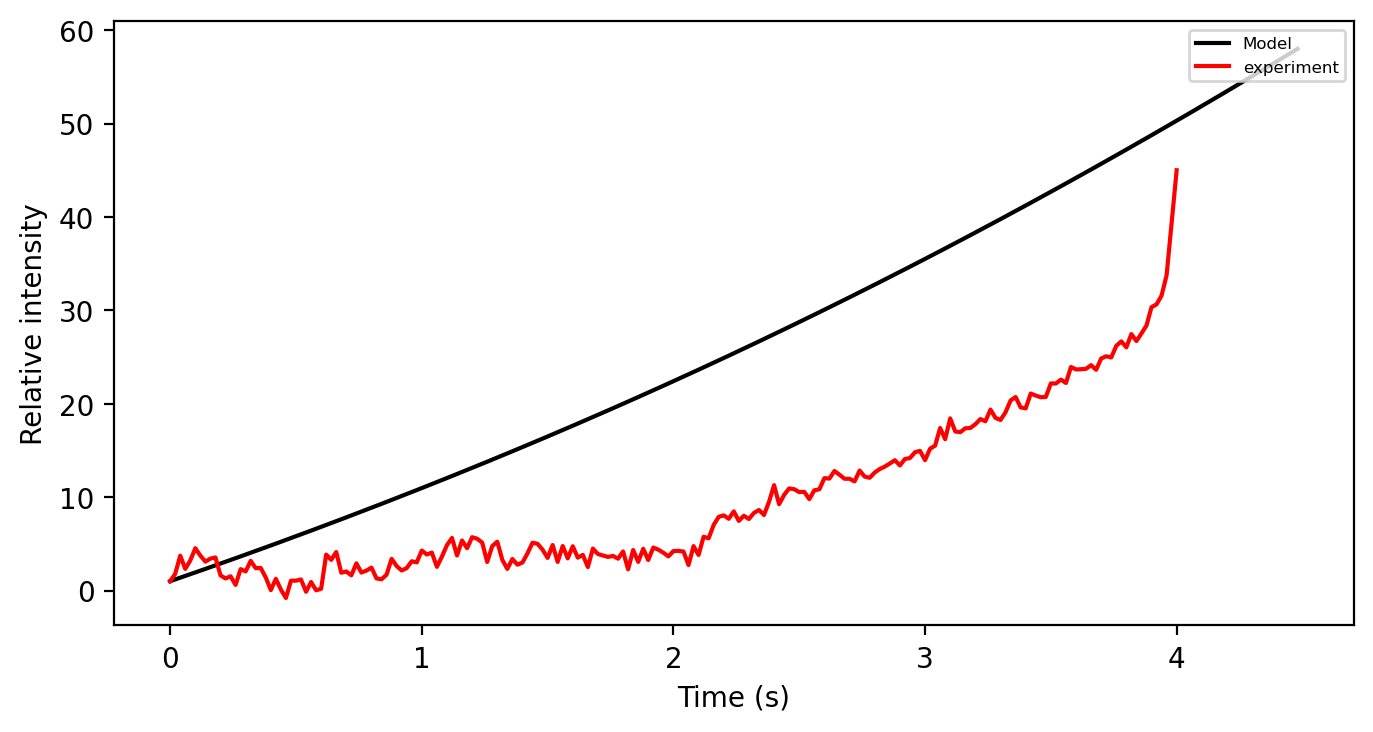

wrote to file
done with all 4 generations.


In [70]:

#print("Rate ratio: " + str(rateRatio)+ " densityRatio: "+ str(densRatio))
model = Oscillator(parameter_ranges, paramsToOpt, mode=0) 
popSize=4000
nGen = 4
nSamples = 2e3
solver = Solver(model, popSize, nGen, nSamples)         
#estimate the initial viable set 
[viablePoints, viableFitness, twoDVals] = solver.findNominalValues()
print("viableFitness[0][0]: "+ str(viableFitness[0][0]))
print("viablePoints[0]: "+ str(viablePoints[0]))
solver.write_sortedParms(viablePoints, viableFitness, twoDVals)
print("wrote to file")
print("done with all " + str(nGen)+ " generations.")